# SRGAN (Super Resolution GAN)

This notebook contains the code and training used for the SRGAN. It uses the GAN setup to train a Super Resolving Generator, tasked with taking low-res images as input and generating high-res images as output, and the Discriminator, which is tasked with distinguishing between images generated by the Generator and real high-res images from the dataset. 

We found that training the G and D together from random initializations resulted in the G creating strange looking images that fooled the D but looked nothing like real images. To try to help the process along, we trained the G alone, at least until it output images that resembled the input images, and then we used those weights as the initialization for the G when training it in the GAN setup.

Ultimately, we found that a GAN tended to make very realistic images, but it was not the best performer on the MSE loss metric. It tended to hallucinate details where there were none, causing the images to look real, but not like the true image.

Many of the functions related to training the GAN were adapted from the GAN notebook in Homework 3 of Stanford's CS231n course. 

# Sections

[Data Loader](#Data-Loader)

[Loss functions](#Loss-functions)

[Network Architectures](#Network-Architectures)

[Generator and Discriminator test](#Generator-and-Discriminator-test)

[Training Helper Functions](#Training-Helper-Functions)

[Training GAN](#Training-GAN)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, sampler, TensorDataset
from torch.utils.data import sampler

import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import numpy as np
import pickle
import os
from PIL import Image

from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.filters import gaussian_filter

import h5py

from time import time

################## LOGGING-BEGIN #########################
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
################## LOGGING-END ###########################

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# From Assignment 2 PyTorch Notebook
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cuda


# Data Loader

In [3]:
# Adapted from https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py# Adapt 

HEIGHT_INDEX = 200 # Row index at which the crop begins
WIDTH_INDEX = 200  # Column index at which the crop begins

IMG_HEIGHT = 64
IMG_WIDTH = 64
NUM_CHANNELS_IN = 3
NUM_CHANNELS_OUT = 2

TRAIN_FILES = 10
VAL_FILES = 2
TEST_FILES = 3
YEARS_PER_FILE = 10
IMGS_PER_YEAR = 365

TRAIN_MODE = 0
VAL_MODE = 1
TEST_MODE = 2

class SR_Dataset(data.Dataset):
    """
    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    base_folder = 'sr_data'
    elevation_file = 'dem.pkl'
    
    train_list = np.array([
        '1950s.hdf5',
        '1960s.hdf5',
        '1970s.hdf5',
        '1980s.hdf5',
        '1990s.hdf5',
        '2000s.hdf5',
        '2010s.hdf5',
        '2020s.hdf5',
        '2030s.hdf5',
        '2040s.hdf5'
    ])
    
    val_list = np.array([
        '2050s.hdf5',
        '2060s.hdf5'
    ])

    test_list = np.array([
        '2070s.hdf5',
        '2080s.hdf5',
        '2090s.hdf5'
        
    ])

    def __init__(self, root, train=True):
        
        self.root = os.path.expanduser(root)
        self.train = train  # training set or test set
        
        # load elevation data
        fo_in = open(os.path.join(self.root, self.elevation_file), 'rb')
        self.elevation = pickle.load(fo_in)
        fo_in.close()
        elev_mean = np.mean(self.elevation)
        elev_var = np.var(self.elevation)
        self.elevation = (self.elevation - elev_mean) / np.sqrt(elev_var)
        h,w = self.elevation.shape
        self.elevation = self.elevation.reshape((1,h,w))

    in_mean = np.array([1.9028055e-05, 284.676482])
    in_var = np.array([1.5503707e-09, 108.102618])
    out_mean = np.array([1.902273e-05, 284.676482])
    out_var = np.array([2.3926674e-09, 108.102618])
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (low_res, high_res)
        """
#         t1 = time()
        file_idx = index // (YEARS_PER_FILE * IMGS_PER_YEAR)
        img_in_file = index % (YEARS_PER_FILE * IMGS_PER_YEAR)
        year_idx = img_in_file // IMGS_PER_YEAR
        idx_in_year = img_in_file % IMGS_PER_YEAR
        
        f = None
        if self.train == TRAIN_MODE:
            f = h5py.File(os.path.join(self.base_folder, self.train_list[file_idx]), 'r')
        elif self.train == VAL_MODE:
            f = h5py.File(os.path.join(self.base_folder, self.val_list[file_idx]), 'r')
        elif self.train == TEST_MODE:
            f = h5py.File(os.path.join(self.base_folder, self.test_list[file_idx]), 'r')
        
        yr = list(f.keys())[year_idx]
        pr =  f[yr]['pr'][idx_in_year]
        tas = f[yr]['tas'][idx_in_year]
        f.close()
        high_res = np.flip(np.concatenate((pr[np.newaxis,:,:], tas[np.newaxis,:,:])),axis=1)
        
        # Now crop the high_res as soon as we get it
        high_res = high_res[:, HEIGHT_INDEX:(HEIGHT_INDEX+IMG_HEIGHT), WIDTH_INDEX:(WIDTH_INDEX+IMG_WIDTH)]

        # Also crop the elevation data to the same place
        elev_crop = self.elevation[:, HEIGHT_INDEX:(HEIGHT_INDEX+IMG_HEIGHT), WIDTH_INDEX:(WIDTH_INDEX+IMG_WIDTH)]

        # get the input LR image from output HR image by blurring, cropping, then interpolating
        c,h1,w1 = high_res.shape
        blurred = np.zeros_like(high_res)
        blurred = gaussian_filter(high_res, sigma = (0, 0.55, 0.55))
        half_res = blurred[:, ::2, ::2]
        # Code involved in interpolating the blurred image back up to high res resolution
        c,h2,w2 = half_res.shape
        x = np.arange(h2)
        y = np.arange(w2)
        xnew = np.arange(0, h2, h2/h1)
        ynew = np.arange(0, w2, w2/w1)
        low_res = np.zeros_like(high_res)
        for i in range(c):
            f = RectBivariateSpline(x, y, half_res[i, :, :])
            low_res[i, :, :] = f(xnew, ynew)
            
        # Normalize to mean 0, std 1 using precomputed statistics from the dataset
        low_res =  (low_res -  self.in_mean[:,np.newaxis,np.newaxis])  / np.sqrt(self.in_var[:,np.newaxis,np.newaxis])
        high_res = (high_res - self.out_mean[:,np.newaxis,np.newaxis]) / np.sqrt(self.out_var[:,np.newaxis,np.newaxis])
        
        # Add the elevation data to the input image
        low_res = np.concatenate((low_res, elev_crop))
        
        # Set the range of values of the training data from 0 to 1, and high res from -1 to 1, as they do in Ledig
        low_res -= np.amin(low_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        low_res /= np.amax(low_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        
        
        high_min = np.amin(high_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        high_max = np.amax(high_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        is_nan = np.int(high_min[0] == high_max[0] or high_min[1] == high_max[1])
        eps = 1e-9
        high_res = (high_res - high_min) / ((high_max - high_min + is_nan*eps) / 2) - 1
        
        
        if np.isnan(high_res).any():
            print("CREATED A NAN")
            print("high_min: ", high_min)
            print("high_max: ", high_max)
            print("year index: ", year_idx)
            print("idx in year: ", idx_in_year)
            print("pr contain nans? ", np.isnan(pr).any())
            print("tas contains nans? ", np.isnan(tas).any())
            
        
        # Gotta cast the lowres to float (from double) else it confuses the model, since model's standard
        # is to assume float
        low_res = torch.from_numpy(low_res).float() 
        high_res = torch.from_numpy(high_res).float()      
        
        #print(time()-t1)
        return low_res, high_res

    def __len__(self):
        if self.train:
            return len(self.train_in)
        else:
            return len(self.test_in)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [10]:
data_directory = '.'

##########################################################################################
#                                  BATCH_SIZE PARAMETER
BATCH_SIZE = 1000
##########################################################################################


sr_train = SR_Dataset(data_directory, train=TRAIN_MODE)
loader_train = DataLoader(sr_train, batch_size=BATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(TRAIN_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)),
                         num_workers = 4)


sr_val = SR_Dataset(data_directory, train=VAL_MODE)
loader_val = DataLoader(sr_val, batch_size=BATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(VAL_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)),
                         num_workers = 4)

sr_test = SR_Dataset(data_directory, train=TEST_MODE)
loader_test = DataLoader(sr_test, batch_size=BATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(TEST_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)),
                         num_workers = 4)


In [38]:
# Check to make sure the range on the input and output images is correct, and they're the correct shape
testx, testy = sr_train.__getitem__(3)
print("x shape: ", testx.shape)
print("y shape: ", testy.shape)
print("x min: ", torch.min(testx))
print("x max: ", torch.max(testx))
print("y min: ", torch.min(testy))
print("y max: ",torch.max(testy))

for x, y in loader_train:
    print(x.shape)
    break

x shape:  torch.Size([3, 64, 64])
y shape:  torch.Size([2, 64, 64])
x min:  tensor(0.)
x max:  tensor(1.)
y min:  tensor(-1.)
y max:  tensor(1.)
torch.Size([16, 3, 64, 64])


# Loss functions

In [39]:
def discriminator_loss(logits_real, logits_fake):
    """
    
    Adapted from homework 3 of CS231n at Stanford, GAN notebook
    
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data (real numbers). 
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data (real numbers).
    
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    # How often it mistakes real images for fake
    N = logits_real.shape[0]
    real_labels = torch.ones(N).to(device=device, dtype=dtype)
    BCE_Loss = nn.BCELoss()
    L1 = BCE_Loss(logits_real, real_labels)
        
    # How often it gets fooled into thinking fake images are real
    fake_labels = torch.zeros(N).to(device=device, dtype=dtype)
    L2 = BCE_Loss(logits_fake, fake_labels)
    
#     print("L1 (how bad on real data): %f\t L2 (how bad on fake data): %f" % (L1, L2))
    
    loss = (L1 + L2)
    return loss, L1, L2

In [40]:
def generator_loss(gen_img, true_img, logits_fake, weight_param=1e-3):
    """
    Computes the generator loss described above.

    Inputs:
    - gen_img: (PyTorch tensor) shape N, C image generated by the Generator, so that we can calculate MSE
    - true_img: (PyTorch tensor) the true, high res image, so that we can calculate the MSE
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    - weight_param: how much to weight the adversarial loss by when summing the losses. Default in Ledig paper is 1e-3
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    # Content loss - MSE loss for now. Ludig paper also suggests using
    # Euclidean distance between feature vector of true image and generated image, 
    # where we get the feature vector from a pretrained VGGnet. Probably wouldn't
    # work for us (at least pretrained) because climate data looks so different from normal pictures
    content_loss_func = nn.MSELoss()
    content_loss = content_loss_func(gen_img, true_img)
        
    N = logits_fake.shape[0]
    desired_labels = torch.ones(N).to(device=device, dtype=dtype)
    BCE_Loss = nn.BCELoss()
    adversarial_loss = BCE_Loss(logits_fake, desired_labels)
    
    total_loss = content_loss + weight_param*adversarial_loss
#     print("Total loss: ", total_loss.cpu().detach().numpy())
#     print("content loss: ", content_loss.cpu().detach().numpy())
#     print("adversarial loss: ", adversarial_loss.cpu().detach().numpy())
    return total_loss, content_loss, adversarial_loss
    
    

In [41]:
def get_optimizer(model, lr=1e-3):
    """
    Copied from CS231n Homework 3's GAN notebook since we use the training function from there too anyways
    
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.9))
#     optimizer = torch.optim.SGD(model.parameters(), lr=lr, )
    return optimizer

# Network Architectures

In [5]:
# Convenience 
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [6]:
class Discriminator(nn.Module):
    def __init__(self, num_channels, H=IMG_HEIGHT, W=IMG_WIDTH):
        super().__init__()
        
        self.layers = nn.Sequential( 
            nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            Flatten(),
            nn.Linear(512*np.ceil(H/16)*np.ceil(W/16), 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
            
        )
        
    def forward(self, x):
        return self.layers(x)

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.ReplicationPad2d(1),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),
            nn.BatchNorm2d(64)
        )

    def forward(self, x):
        return x + self.layers(x)

class UpscaleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(64, 256, 3, stride=1, padding=0),
            nn.PixelShuffle(upscale_factor=2),
            nn.PReLU()
        )
    
    def forward(self, x):
        return self.layers(x)
        

class Generator(nn.Module):
    def __init__(self, num_channels, num_res_blocks=16, scale_factor=2):
#         upsample_block_num = int(math.log(scale_factor, 2))

        super().__init__()
        # Store the number of residual blocks, we need this number in the forward() function
        self.num_res_blocks = num_res_blocks
        
        self.initial_conv = nn.Sequential(
            nn.ReplicationPad2d(4),
            nn.Conv2d(num_channels, 64, kernel_size=9, stride=1, padding=0),
            nn.PReLU()
        )
        
        # List of residual blocks
        self.resBlocks = nn.ModuleList([ResidualBlock(64) for i in range(self.num_res_blocks)])

        self.post_resid_conv = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),
            nn.BatchNorm2d(64)
        )
    
        # We chose to remove the pixelshuffle blocks and instead interpolate ahead of time
        # This allows us to leverage the fact that the elevation data is also high resolution
        # since if we used pixelshuffle, we would need to have the elevation data at lowres in input
#         self.num_upscale_blocks = scale_factor // 2
#         self.upscaleBlocks = nn.ModuleList([UpscaleBlock() for i in range(self.num_upscale_blocks)])
        
        # Instead, just do one conv-prelu block, without the pixelshuffle in between
        self.conv_prelu = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),
            nn.PReLU()
        )
    
        self.final_conv = nn.Sequential(
            nn.ReplicationPad2d(4),
            nn.Conv2d(64, 2, 9, stride=1, padding=0)
        )


    def forward(self, x):
        initial_conv_out = self.initial_conv(x)
                
        res_block_out = self.resBlocks[0](initial_conv_out)
        for i in range(1, self.num_res_blocks):
            res_block_out = self.resBlocks[i](res_block_out)

        post_resid_conv_out = self.post_resid_conv(res_block_out) + initial_conv_out
        conv_prelu_out = self.conv_prelu(post_resid_conv_out)
        final_out = self.final_conv(conv_prelu_out)


        return F.tanh(final_out) 

# Generator and Discriminator test

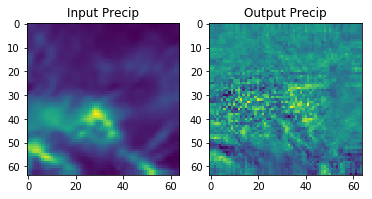

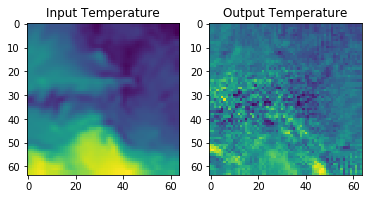

In [45]:
def test_Generator():
    h = 32
    w = h
#     x = torch.zeros((1, NUM_CHANNELS_IN, h, w), dtype=dtype) 
    x = (sr_train.__getitem__(3)[0]).unsqueeze_(0)
    model = Generator(NUM_CHANNELS_IN, scale_factor=2)
    model = model.to(device=device)
    x = x.to(device=device, dtype=dtype)
    output = model(x)
#     print(np.amin(output[0,1,:,:].detach().numpy()))
    plt.subplot(121)
    plt.imshow(x.cpu().detach().numpy()[0, 0, :, :])
    plt.title("Input Precip")
    plt.subplot(122)
    plt.imshow(output.cpu().detach().numpy()[0, 0, :, :])
    plt.title("Output Precip")
    plt.figure()
    plt.subplot(121)
    plt.imshow(x.cpu().detach().numpy()[0, 1, :, :])
    plt.title("Input Temperature")
    plt.subplot(122)
    plt.imshow(output.cpu().detach().numpy()[0, 1, :, :])
    plt.title("Output Temperature")
    plt.show()
test_Generator()

In [46]:
def test_Discriminator():
    x = (sr_train.__getitem__(3)[0]).unsqueeze_(0)
    print("x: ", x.shape)
    model = Discriminator(NUM_CHANNELS_IN)
    output = model(x)
    print(output.size())
    print(output)
test_Discriminator()

x:  torch.Size([1, 3, 64, 64])
torch.Size([1, 1])
tensor([[ 0.5093]])


# Training Helper Functions

In [8]:
def check_generator_accuracy(loader, model):
    
#     if loader.dataset.train == TRAIN_MODE:
#         print('Checking accuracy on train set')
#     elif loader.dataset.train == VAL_MODE:
#         print('Checking accuracy on validation set')
#     elif loader.dataset.train == TEST_MODE:
#         print('Checking accuracy on test set')
    model.eval() # set model to evaluation mode
    count, rmse_precip_ypred, rmse_precip_x, rmse_temp_ypred, rmse_temp_x = 0, 0, 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            model = model.to(device=device)
            y = y.to(device=device, dtype=dtype)
            
            # Normalize x to be in -1 to 1 for purpose of comparing with high res data in same range
            # Turn it into a numpy array
            x_np = x.numpy()
            x_min = np.amin(x_np, axis=(2,3))[:, :, np.newaxis, np.newaxis]
            x_max = np.amax(x_np, axis=(2,3))[:, :, np.newaxis, np.newaxis]
            is_nan = np.int((x_min == x_max).any())
            eps = 1e-9
            x_norm_np = (x_np - x_min) / ((x_max - x_min + is_nan*eps) / 2) - 1
            
            x_norm = torch.from_numpy(x_norm_np)
            x_norm = x_norm.to(device=device, dtype=dtype)
            x = x.to(device=device, dtype=dtype)
            
            y_predicted = model(x)
            rmse_precip_ypred += torch.sqrt(torch.mean((y_predicted[:,0,:,:]-y[:,0,:,:]).pow(2)))
            rmse_precip_x += torch.sqrt(torch.mean((x_norm[:,0,:,:]-y[:,0,:,:]).pow(2)))
            rmse_temp_ypred += torch.sqrt(torch.mean((y_predicted[:,1,:,:]-y[:,1,:,:]).pow(2)))
            rmse_temp_x += torch.sqrt(torch.mean((x_norm[:,1,:,:]-y[:,1,:,:]).pow(2)))
            count += 1
            
        rmse_precip_ypred /= count
        rmse_precip_x /= count
        rmse_temp_ypred /= count
        rmse_temp_x /= count
        print('RMSEs: \tInput precip: %.3f\n\tOutput precip: %.3f\n\tInput temp: %.3f\n\tOutput temp: %.3f\n\t' % 
              (rmse_precip_x, rmse_precip_ypred, rmse_temp_x, rmse_temp_ypred))
        
def check_discriminator_accuracy(loader, D, G):
    D = D.to(device=device)
    G = G.to(device=device)
#     if loader.dataset.train == TRAIN_MODE:
#         print('Checking accuracy on train set')
#     elif loader.dataset.train == VAL_MODE:
#         print('Checking accuracy on validation set')
#     elif loader.dataset.train == TEST_MODE:
#         print('Checking accuracy on test set')
    D.eval() # set model to evaluation mode
    G.eval()
    
    count, avg_true_pred, avg_fake_pred = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            true_pred = D(y)
            avg_true_pred += true_pred.sum()
            count += len(true_pred)
            
            fake_imgs = G(x)
            fake_pred = D(fake_imgs)
            avg_fake_pred += fake_pred.sum()
            
        avg_true_pred /= count
        avg_fake_pred /= count
        print("Average prediction score on real data: %f" % (avg_true_pred))
        print("Average prediction score on fake data: %f" % (avg_fake_pred))

In [48]:
# Helper functions for plotting
def plot_epoch(x, y_pred, y):
    figsize = (9,4)
    plt.figure(figsize=figsize)
    plt.subplot(1,3,1)
    plt.imshow(x[0,0,:,:].cpu().detach().numpy())
    plt.title("Input Precip")
    plt.subplot(1,3,2)
    plt.imshow(y_pred[0,0,:,:].cpu().detach().numpy())
    plt.title("Output Precip")
    plt.subplot(1,3,3)
    plt.imshow(y[0,0,:,:].cpu().detach().numpy())
    plt.title("True Precip")
    
    plt.figure(figsize=figsize)
    plt.subplot(1,3,1)
    plt.imshow(x[0,1,:,:].cpu().detach().numpy())
    plt.title("Input Temp")
    plt.subplot(1,3,2)
    plt.imshow(y_pred[0,1,:,:].cpu().detach().numpy())
    plt.title("Output Temp")
    plt.subplot(1,3,3)
    plt.imshow(y[0,1,:,:].cpu().detach().numpy())
    plt.title("True Temp")
    plt.show()
    
def plot_loss(G_content, G_advers, D_real_L, D_fake_L, weight_param):
    
    D_count = np.count_nonzero(D_real_L)
    G_count = np.count_nonzero(G_content)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(range(G_count), G_content[range(G_count)])
    plt.plot(range(G_count), G_advers[range(G_count)])
    plt.plot(range(G_count), G_content[range(G_count)] + weight_param*G_advers[range(G_count)])
    plt.legend(("Content", "Adversarial", "Total"))
    plt.title("Generator loss")
    plt.xlabel("Iteration")
    
    plt.subplot(1,2,2)
    plt.plot(range(D_count), D_real_L[range(D_count)])
    plt.plot(range(D_count), D_fake_L[range(D_count)])
    plt.plot(range(D_count), D_real_L[range(D_count)] + D_fake_L[range(D_count)])
    plt.legend(("Real Pic", "Fake Pic", "Total"))
    plt.title("Discriminator loss")
    plt.xlabel("Iteration")
    plt.show()

# Training GAN

In [18]:
################## LOGGING-BEGIN #########################
# how often to log images
save_img_every = 150
exp_name = 'experiments/adverWP_-1'
writer = SummaryWriter(exp_name)
################## LOGGING-END ###########################

In [20]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, G_iters=1, show_every=250, num_epochs=5):
    """
    Adapted from CS231n Homework 3's GAN notebook
    
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    # Move the models to the correct device (GPU if GPU is available)
    D = D.to(device=device)
    G = G.to(device=device)
    
    # Put models in training mode
    D.train()
    G.train()
    
    print("Expected num iters: ", len(loader_train)*num_epochs)
    G_content = np.zeros(len(loader_train)*num_epochs*G_iters+1)
    G_advers = np.zeros(len(loader_train)*num_epochs*G_iters+1)
    D_real_L = np.zeros(len(loader_train)*num_epochs+1)
    D_fake_L = np.zeros(len(loader_train)*num_epochs+1)
    
    
    tic = time()
    
    iter_count = 0
    G_iter_count = 0
    for epoch in range(num_epochs):
        for x,y in loader_train:
                
            high_res_imgs = y.to(device=device, dtype=dtype)
            logits_real = D(high_res_imgs)

            x.requires_grad_()
            low_res_imgs = x.to(device=device, dtype=dtype)
            fake_images = G(low_res_imgs)
            logits_fake = D(fake_images)
    
            # Update for the discriminator
            d_total_error, D_real_L[iter_count], D_fake_L[iter_count] = discriminator_loss(logits_real, logits_fake)
            D_solver.zero_grad()
            d_total_error.backward()
            D_solver.step()

            
            for i in range(G_iters):
                # Update for the generator
                fake_images = G(low_res_imgs)
                logits_fake = D(fake_images)
                gen_logits_fake = D(fake_images)
                weight_param = 1e-1 # Weighting put on adversarial loss
                g_error, G_content[G_iter_count], G_advers[G_iter_count] = generator_loss(fake_images, high_res_imgs, gen_logits_fake, weight_param=weight_param)
                G_solver.zero_grad()
                g_error.backward()
                G_solver.step()
                G_iter_count += 1
                
                # Experimenting
#                 g_error, g_content, g_advers = generator_loss(fake_images, high_res_imgs, gen_logits_fake, weight_param=1e3)
#                 G_content[G_iter_count] = g_content
#                 G_advers[G_iter_count] = g_advers
#                 G_solver.zero_grad()
#                 g_advers.backward()
#                 G_solver.step()

            ################## LOGGING-BEGIN #########################
            writer.add_scalar('D Loss (Real)', D_real_L[iter_count], iter_count)
            writer.add_scalar('D Loss (Fake)', D_fake_L[iter_count], iter_count)
            writer.add_scalar('D Loss (Total)', d_total_error, iter_count)
            writer.add_scalar('G Loss (Content)', G_content[iter_count], iter_count)
            writer.add_scalar('G Loss (Adv)', G_advers[iter_count], iter_count)
            writer.add_scalar('G Loss (Total)', g_error, iter_count)
            if iter_count % save_img_every == 0:
                # precip
                input_precip_grid = vutils.make_grid(x[0, 0, :, :])
                writer.add_image('Input precipitation', input_precip_grid, iter_count)
                output_precip_grid = vutils.make_grid(fake_images[0, 0, :, :])
                writer.add_image('Output precipitation', output_precip_grid, iter_count)
                true_precip_grid = vutils.make_grid(y[0, 0, :, :])
                writer.add_image('True precipitation', true_precip_grid, iter_count)
                # temp
                input_temp_grid = vutils.make_grid(x[0, 1, :, :])
                writer.add_image('Input temperature', input_temp_grid, iter_count)
                output_temp_grid = vutils.make_grid(fake_images[0, 1, :, :])
                writer.add_image('Output temperature', output_temp_grid, iter_count)
                true_temp_grid = vutils.make_grid(y[0, 1, :, :])
                writer.add_image('True temperature', true_temp_grid, iter_count)
            ################## LOGGING-END ###########################

            if (iter_count % show_every == 0):
                toc = time()
                print('Epoch: {}, Iter: {}, D: {:.4}, G: {:.4}, Time since last print (min): {:.4}'.format(epoch,iter_count,d_total_error.item(),g_error.item(), (toc-tic)/60 ))
                tic = time()
                plot_epoch(x, fake_images, y)
                plot_loss(G_content, G_advers, D_real_L, D_fake_L, weight_param)
                print()
            iter_count += 1
        torch.save(D.cpu().state_dict(), 'GAN_Discriminator_checkpoint_adversWP_1e-1.pt')
        torch.save(G.cpu().state_dict(), 'GAN_Generator_checkpoint_adversWP_1e-1.pt')
        # Move the models back onto the GPU?
        # Move the models to the correct device (GPU if GPU is available)
        D = D.to(device=device)
        G = G.to(device=device)
        # Put models in training mode
        D.train()
        G.train()
#     print("FINAL ITER COUNT: ", iter_count)

Expected num iters:  4564


/home/shared/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: 0, Iter: 0, D: 1.444, G: 1.166, Time since last print (min): 0.09231


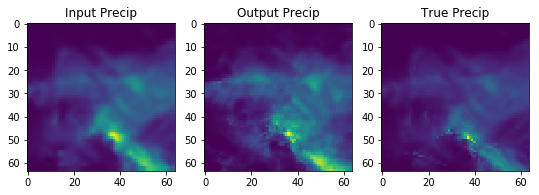

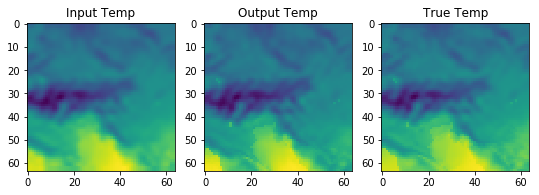

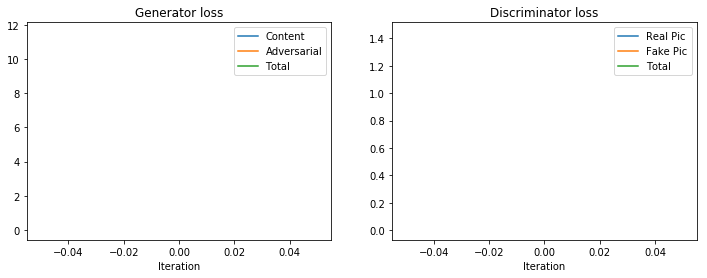


Epoch: 0, Iter: 50, D: 0.6291, G: 0.2409, Time since last print (min): 2.557


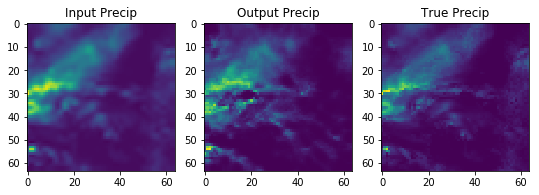

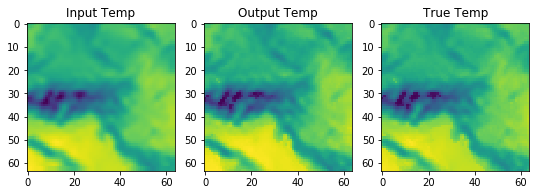

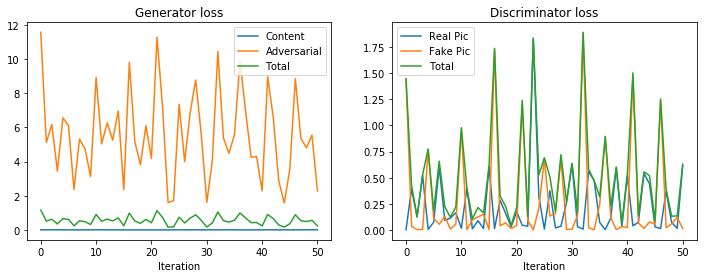


Epoch: 0, Iter: 100, D: 2.018, G: 1.056, Time since last print (min): 2.554


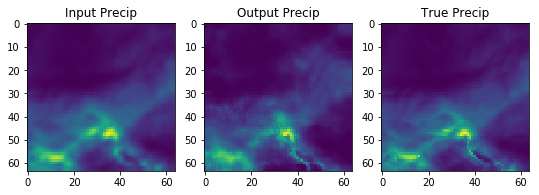

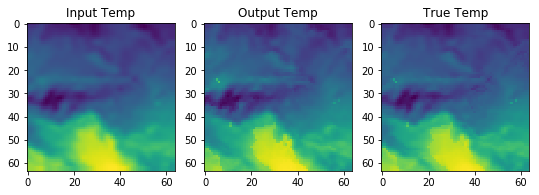

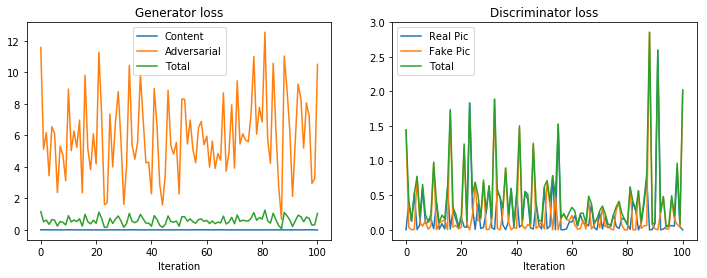


Epoch: 0, Iter: 150, D: 0.1132, G: 0.6995, Time since last print (min): 2.556


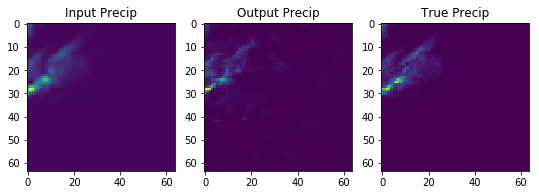

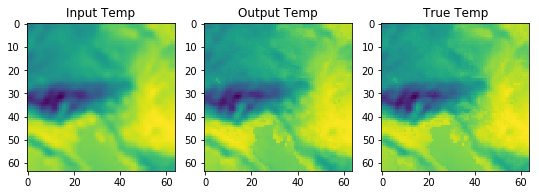

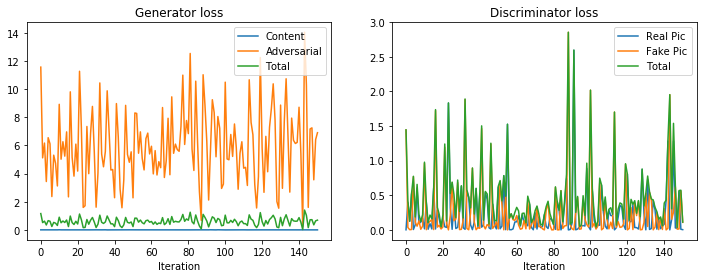


Epoch: 0, Iter: 200, D: 0.9635, G: 0.9504, Time since last print (min): 2.554


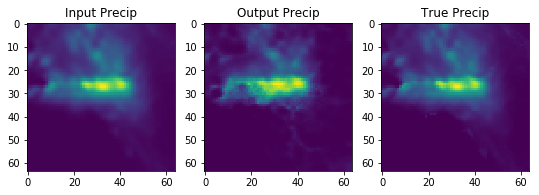

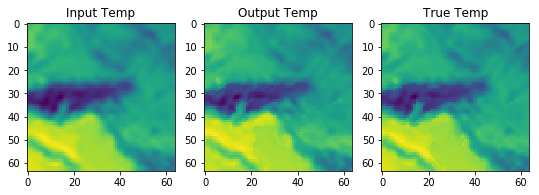

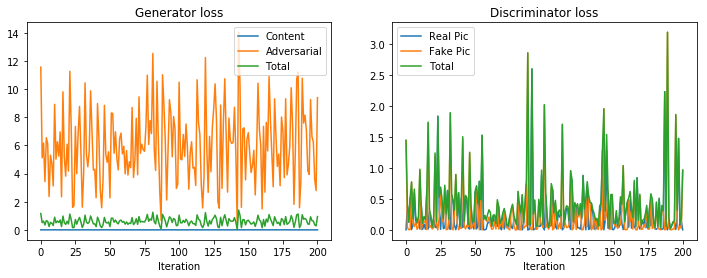


Epoch: 0, Iter: 250, D: 0.5436, G: 0.3483, Time since last print (min): 2.556


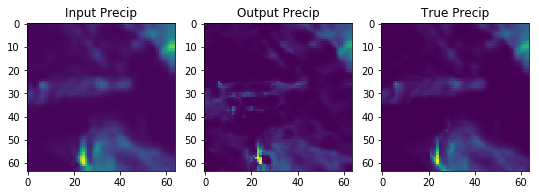

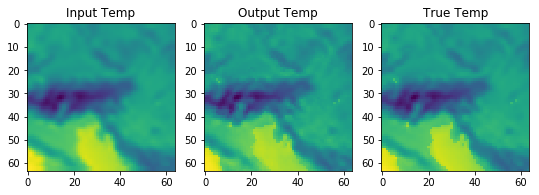

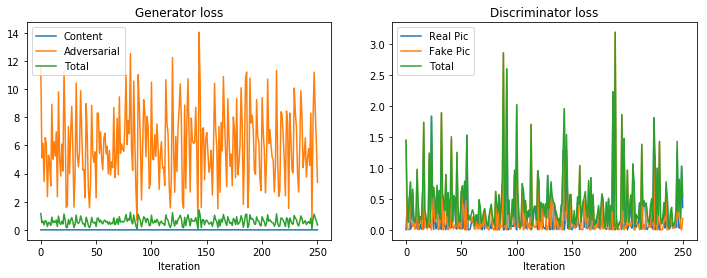


Epoch: 0, Iter: 300, D: 0.3933, G: 0.3571, Time since last print (min): 2.555


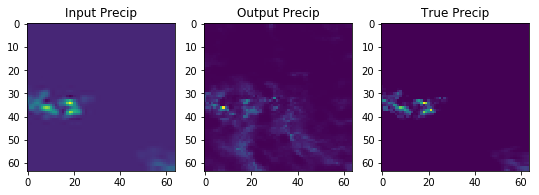

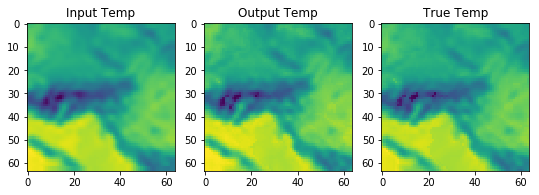

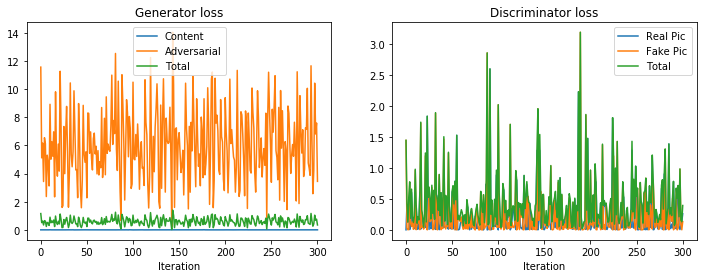


Epoch: 0, Iter: 350, D: 0.2292, G: 0.6717, Time since last print (min): 2.555


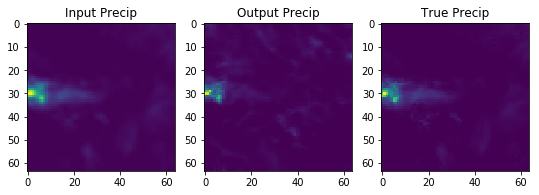

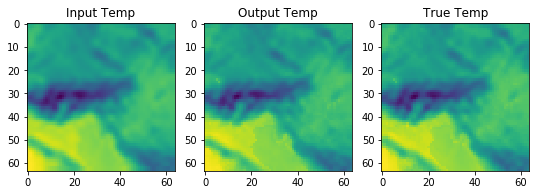

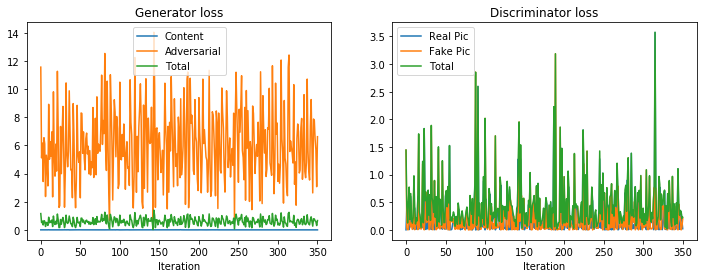


Epoch: 0, Iter: 400, D: 0.2881, G: 0.5345, Time since last print (min): 2.555


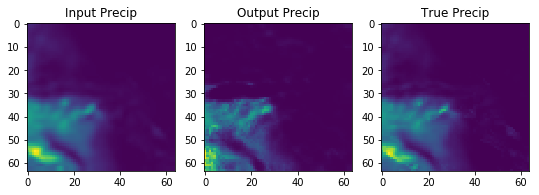

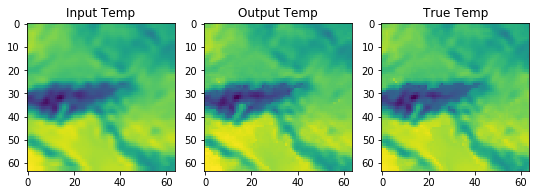

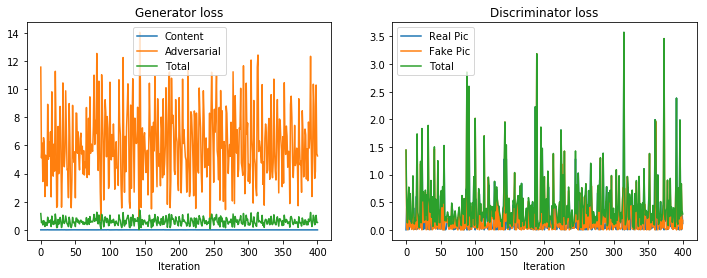


Epoch: 0, Iter: 450, D: 0.05177, G: 0.4698, Time since last print (min): 2.555


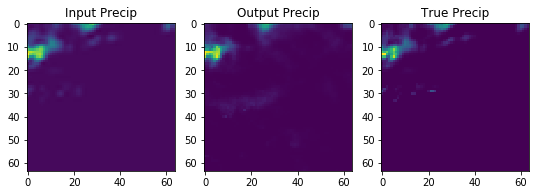

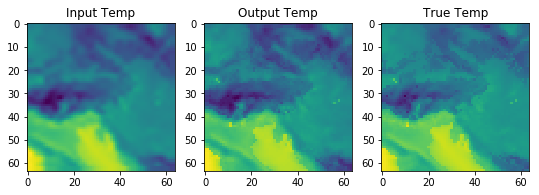

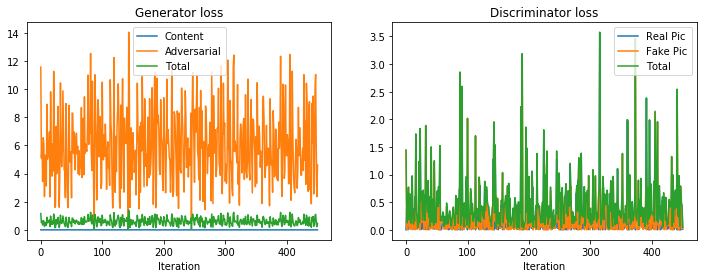


Epoch: 0, Iter: 500, D: 1.594, G: 0.02544, Time since last print (min): 2.555


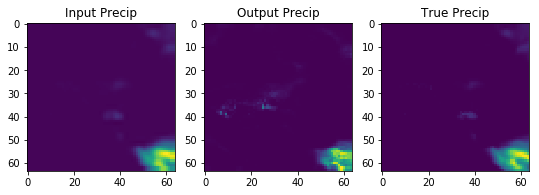

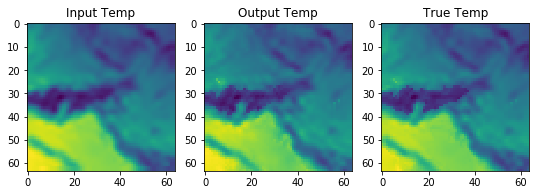

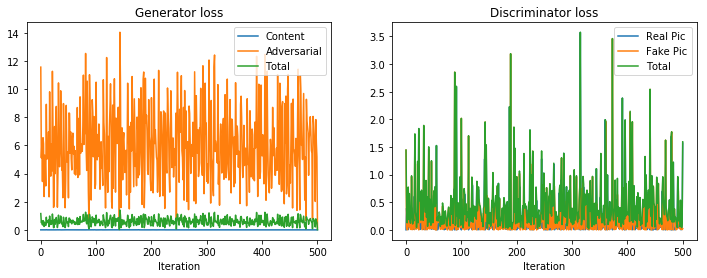


Epoch: 0, Iter: 550, D: 0.7495, G: 0.89, Time since last print (min): 2.554


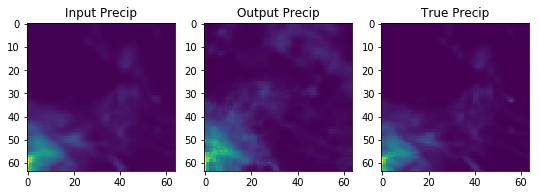

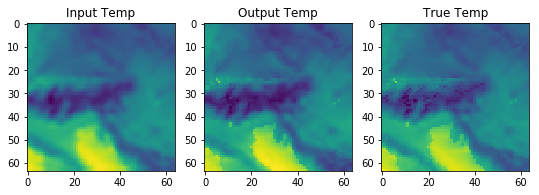

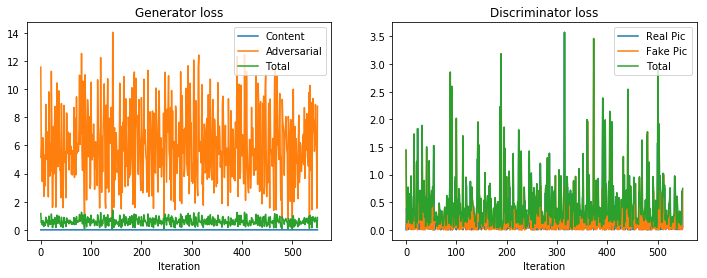


Epoch: 0, Iter: 600, D: 0.09533, G: 0.4443, Time since last print (min): 2.556


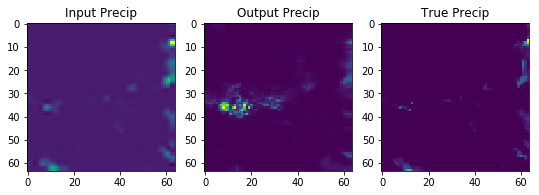

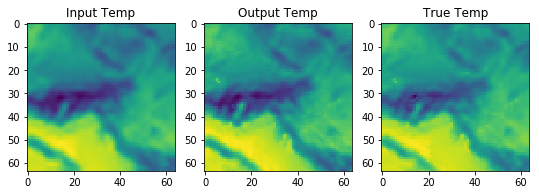

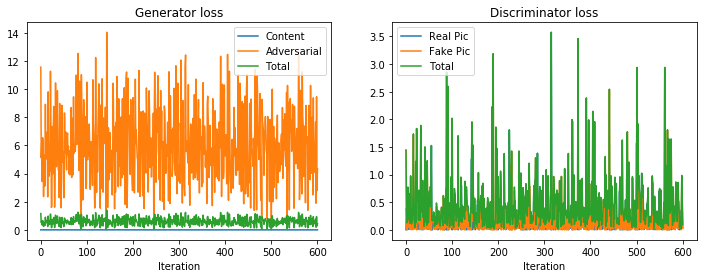


Epoch: 0, Iter: 650, D: 0.04178, G: 0.5236, Time since last print (min): 2.556


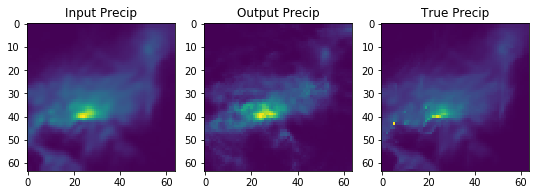

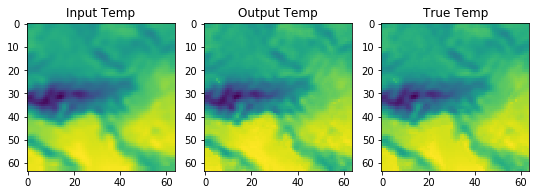

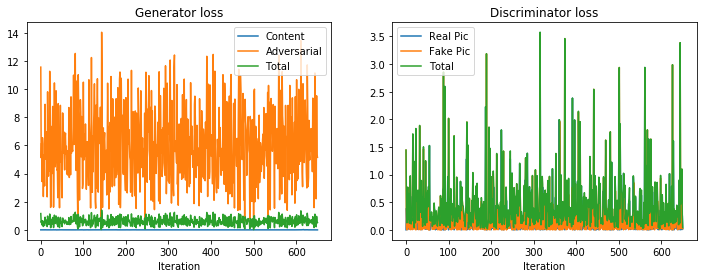


Epoch: 0, Iter: 700, D: 0.2154, G: 0.4264, Time since last print (min): 2.554


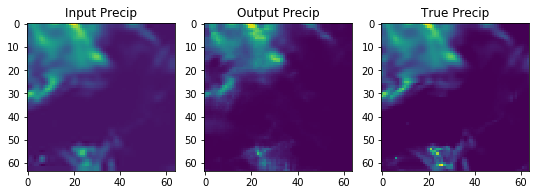

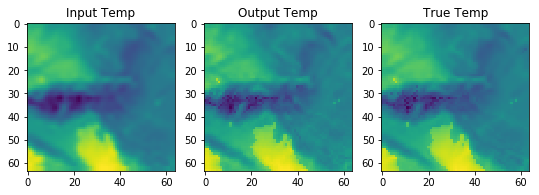

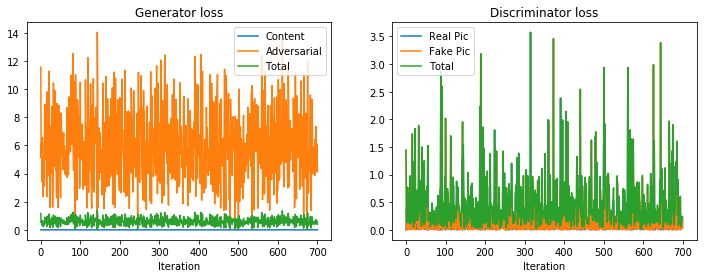


Epoch: 0, Iter: 750, D: 0.2176, G: 0.7189, Time since last print (min): 2.556


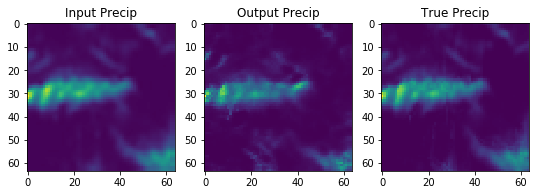

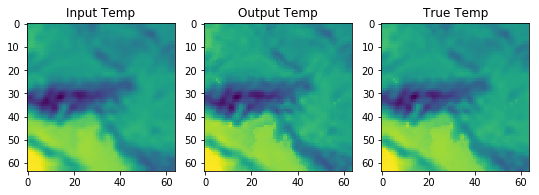

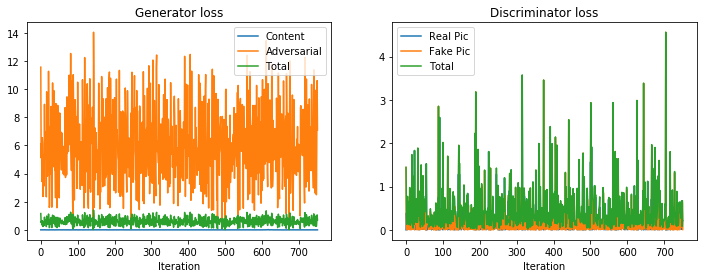


Epoch: 0, Iter: 800, D: 0.154, G: 0.5345, Time since last print (min): 2.555


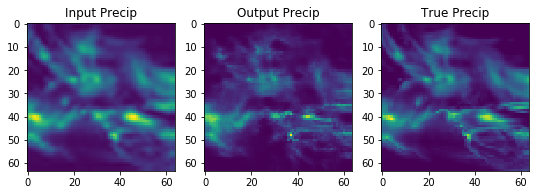

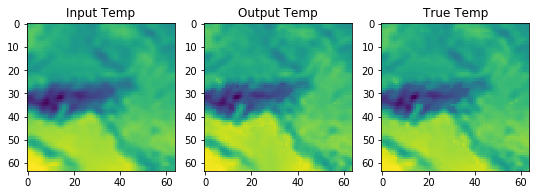

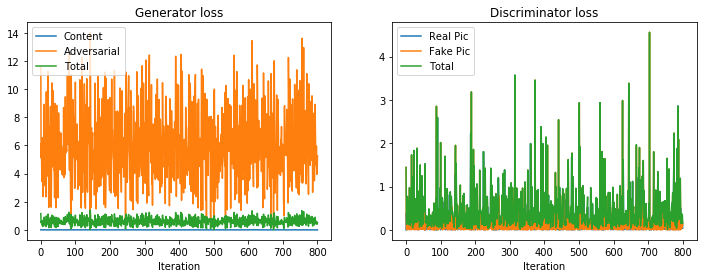


Epoch: 0, Iter: 850, D: 0.7538, G: 0.2698, Time since last print (min): 2.556


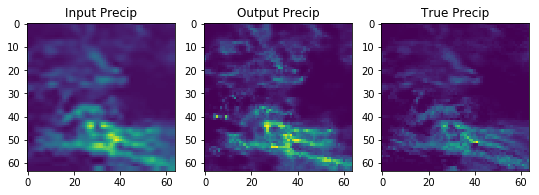

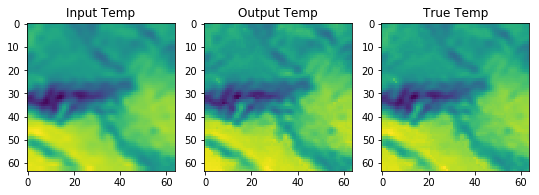

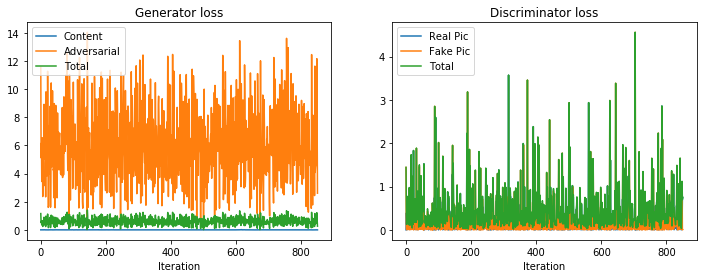


Epoch: 0, Iter: 900, D: 0.07355, G: 0.3969, Time since last print (min): 2.555


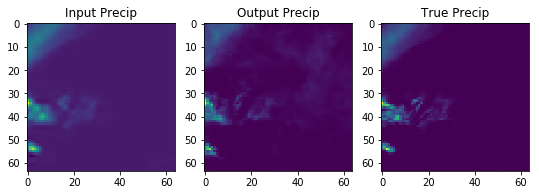

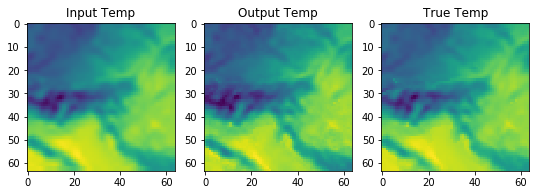

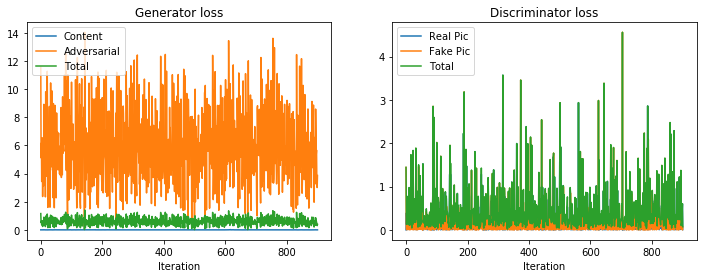


Epoch: 0, Iter: 950, D: 0.8898, G: 0.9433, Time since last print (min): 2.555


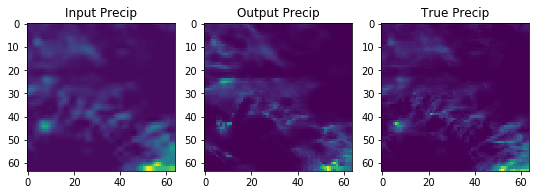

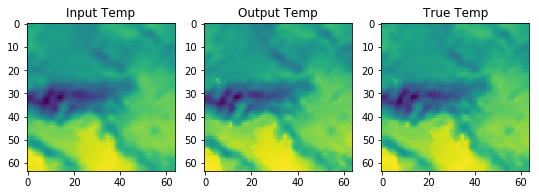

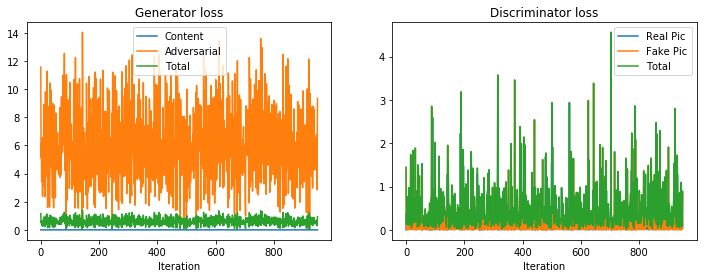


Epoch: 0, Iter: 1000, D: 0.2446, G: 0.4157, Time since last print (min): 2.555


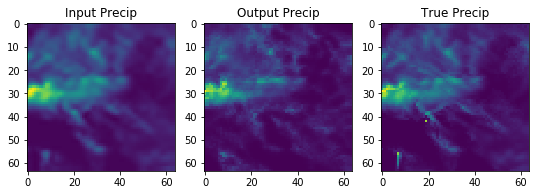

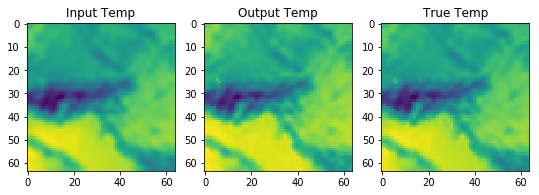

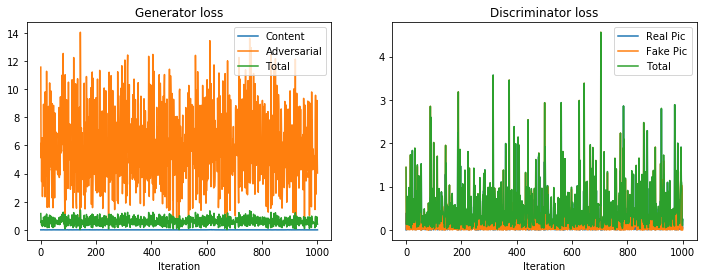


Epoch: 0, Iter: 1050, D: 0.1627, G: 0.5658, Time since last print (min): 2.555


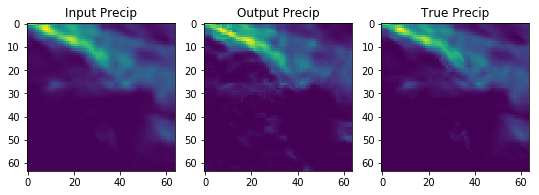

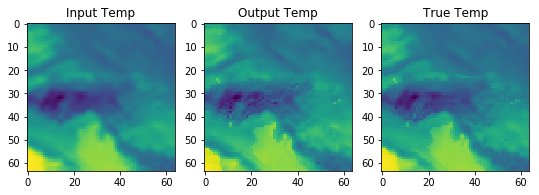

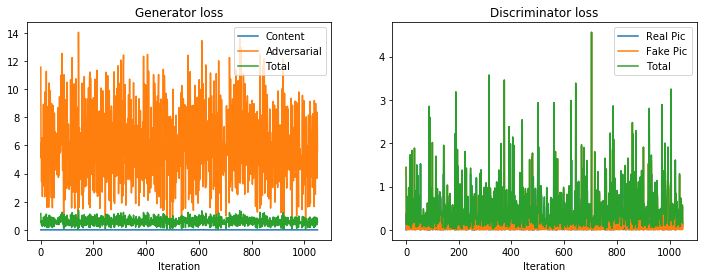


Epoch: 0, Iter: 1100, D: 0.7222, G: 0.931, Time since last print (min): 2.555


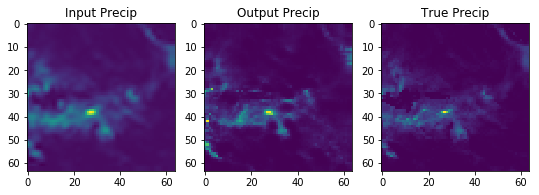

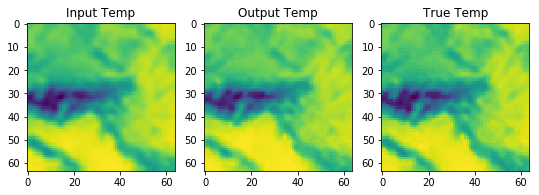

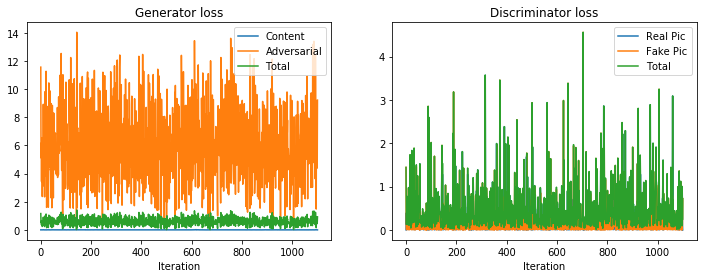


Epoch: 0, Iter: 1150, D: 0.1668, G: 0.4085, Time since last print (min): 2.554


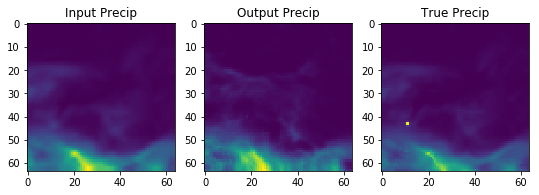

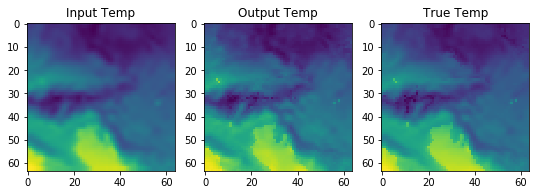

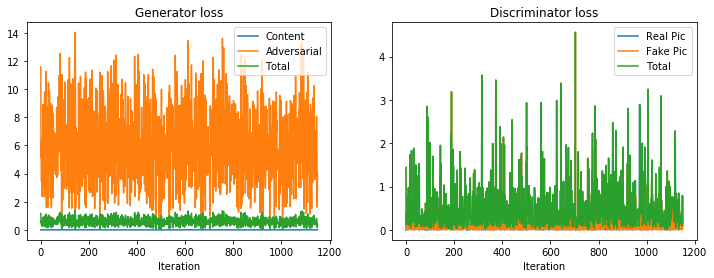


Epoch: 0, Iter: 1200, D: 0.1308, G: 0.3364, Time since last print (min): 2.555


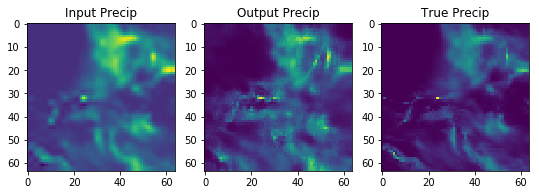

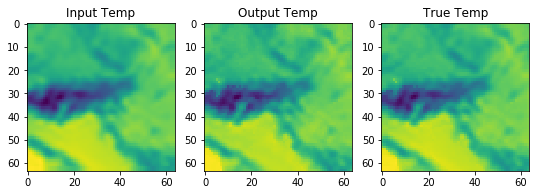

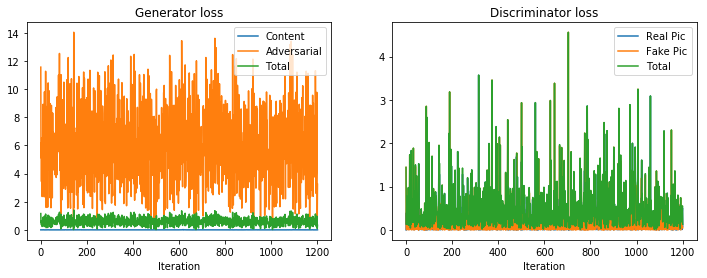


Epoch: 0, Iter: 1250, D: 0.4737, G: 0.8153, Time since last print (min): 2.554


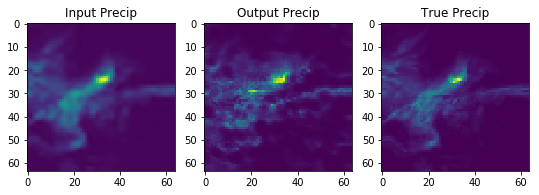

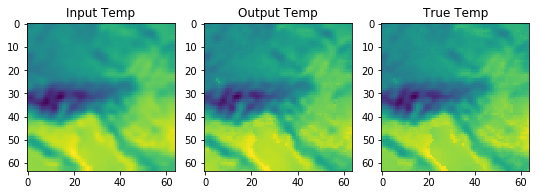

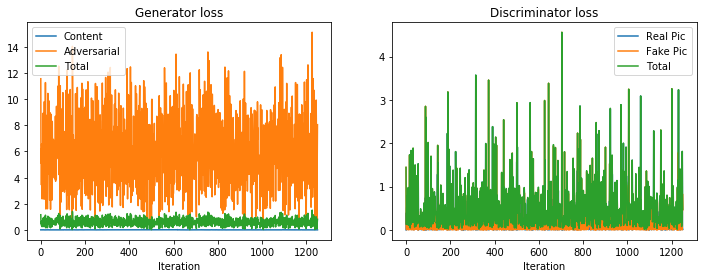


Epoch: 0, Iter: 1300, D: 0.949, G: 0.6978, Time since last print (min): 2.556


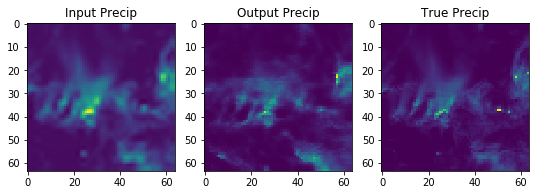

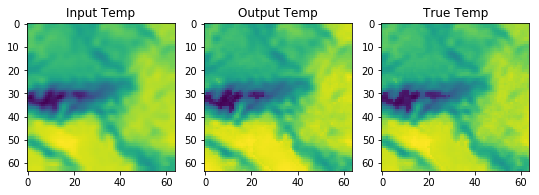

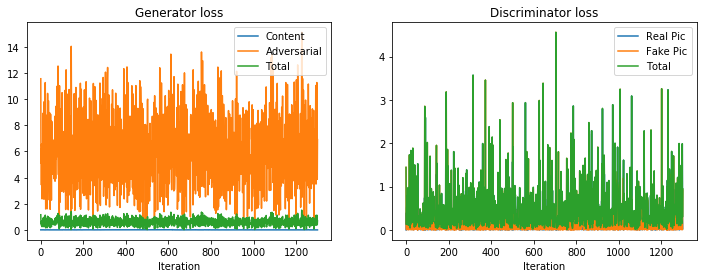


Epoch: 0, Iter: 1350, D: 0.1842, G: 0.335, Time since last print (min): 2.555


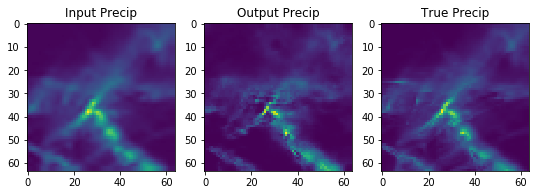

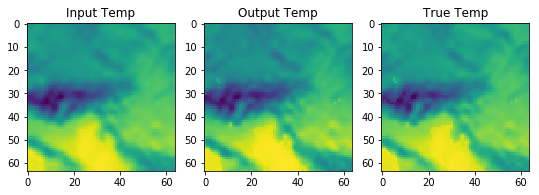

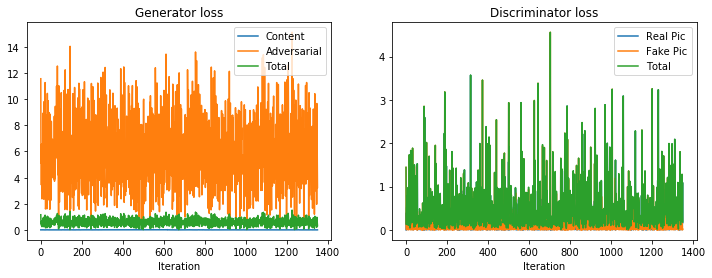


Epoch: 0, Iter: 1400, D: 0.1565, G: 0.5831, Time since last print (min): 2.556


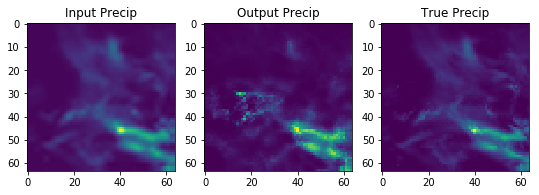

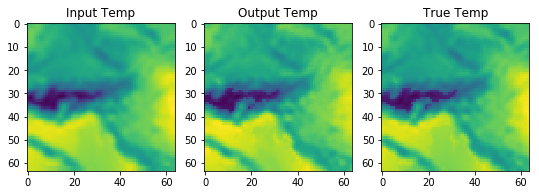

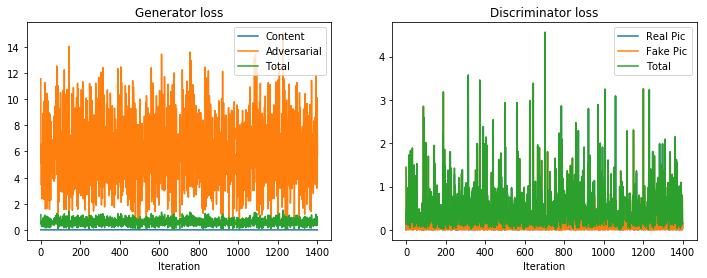


Epoch: 0, Iter: 1450, D: 0.1941, G: 0.667, Time since last print (min): 2.553


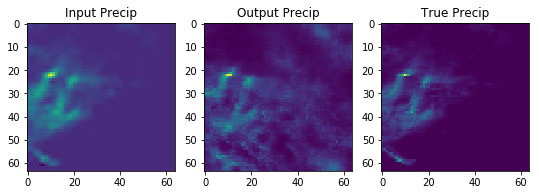

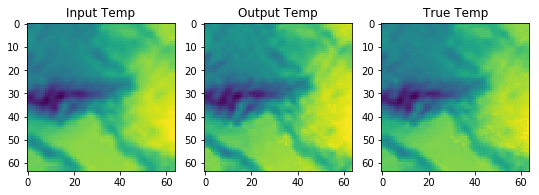

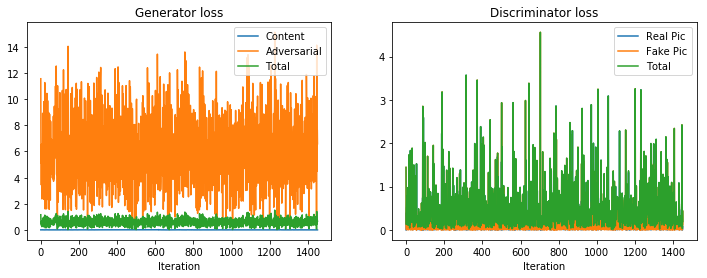


Epoch: 0, Iter: 1500, D: 1.098, G: 0.646, Time since last print (min): 2.545


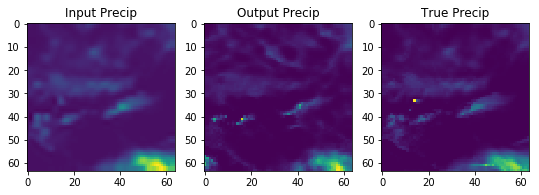

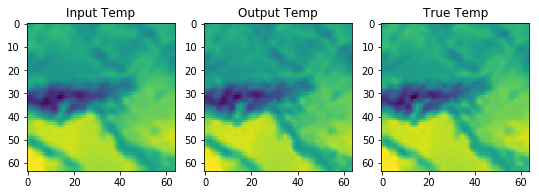

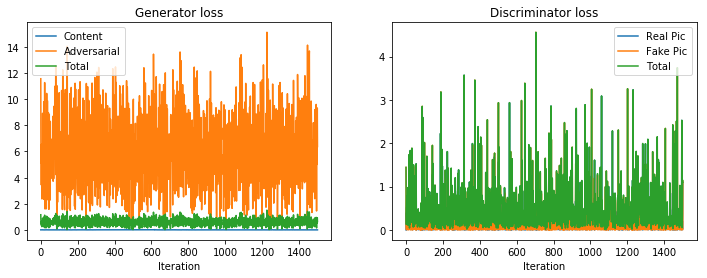


Epoch: 0, Iter: 1550, D: 0.2677, G: 0.706, Time since last print (min): 2.545


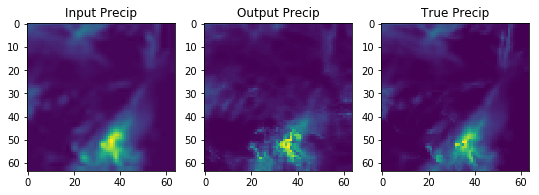

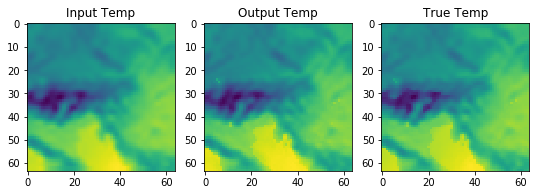

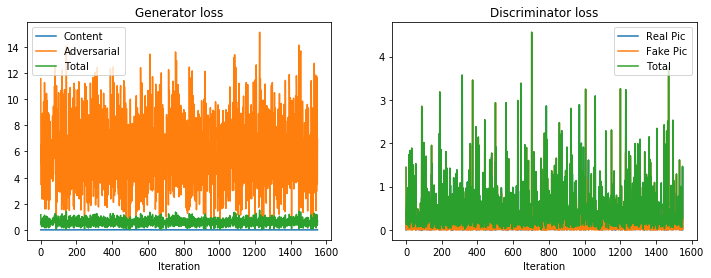


Epoch: 0, Iter: 1600, D: 1.165, G: 1.07, Time since last print (min): 2.547


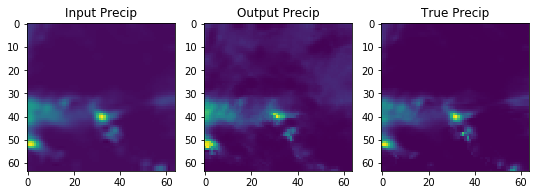

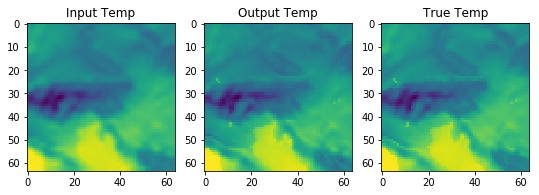

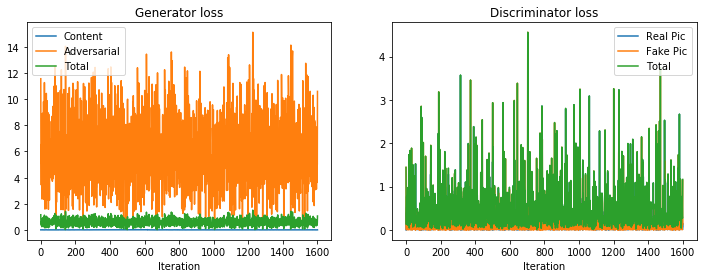


Epoch: 0, Iter: 1650, D: 0.1524, G: 0.6358, Time since last print (min): 2.545


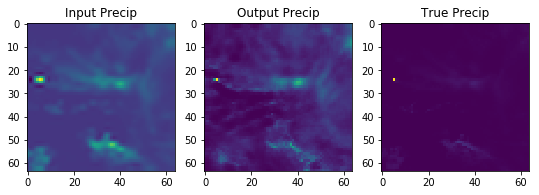

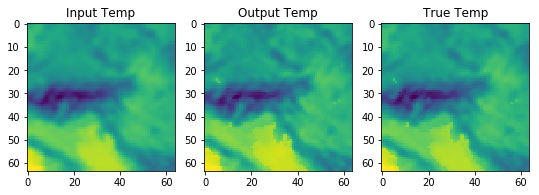

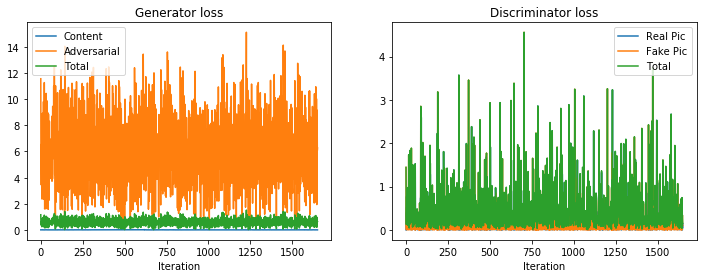


Epoch: 0, Iter: 1700, D: 0.3427, G: 0.6504, Time since last print (min): 2.545


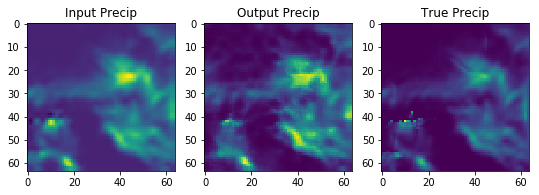

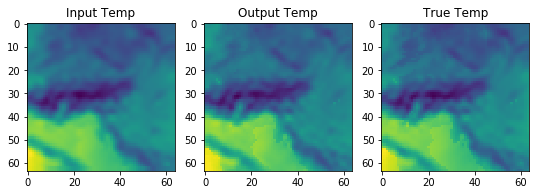

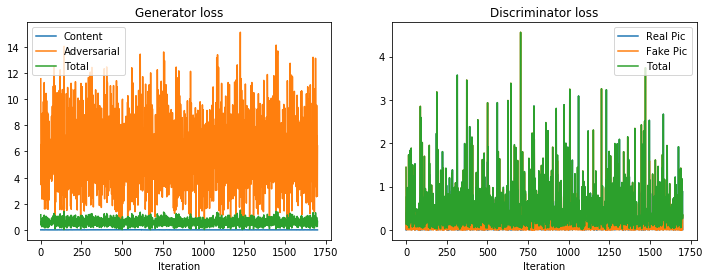


Epoch: 0, Iter: 1750, D: 1.081, G: 0.7711, Time since last print (min): 2.554


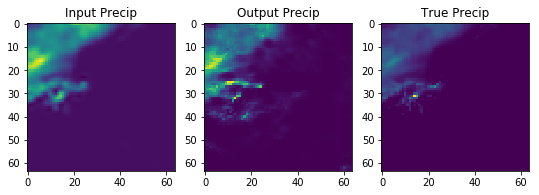

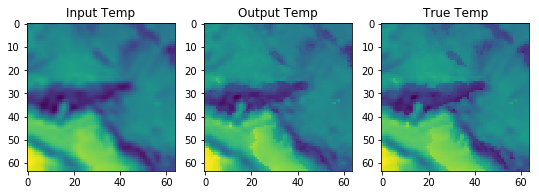

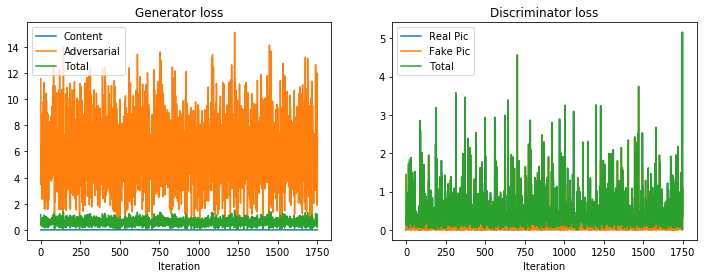


Epoch: 0, Iter: 1800, D: 0.1465, G: 0.5418, Time since last print (min): 2.555


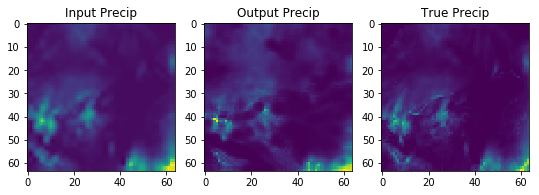

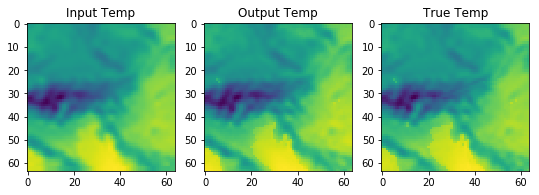

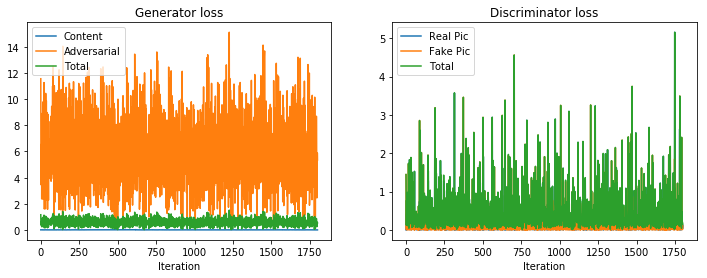


Epoch: 0, Iter: 1850, D: 0.4236, G: 0.2177, Time since last print (min): 2.55


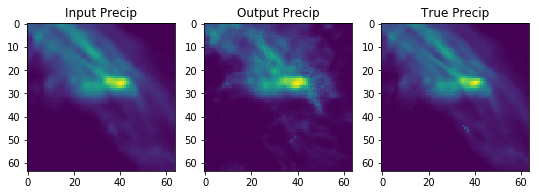

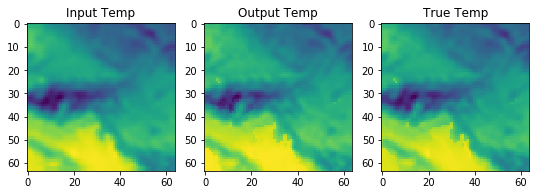

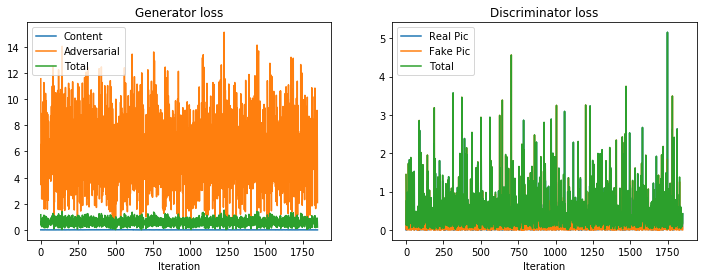


Epoch: 0, Iter: 1900, D: 0.1607, G: 0.7043, Time since last print (min): 2.551


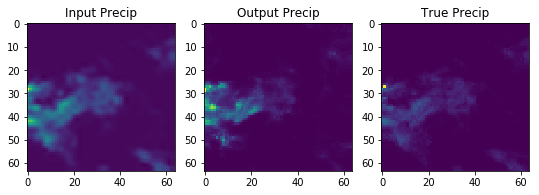

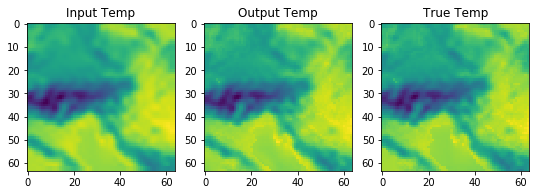

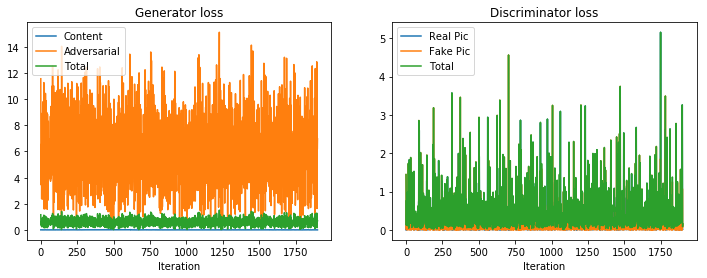


Epoch: 0, Iter: 1950, D: 0.7487, G: 0.9881, Time since last print (min): 2.555


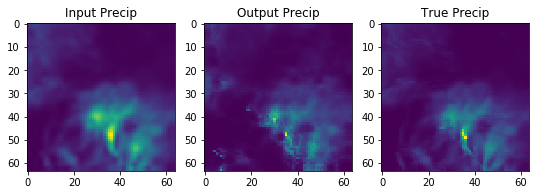

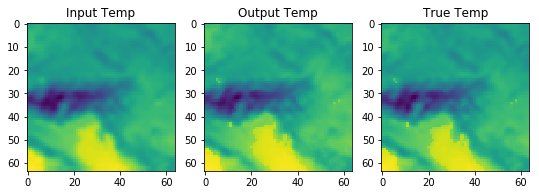

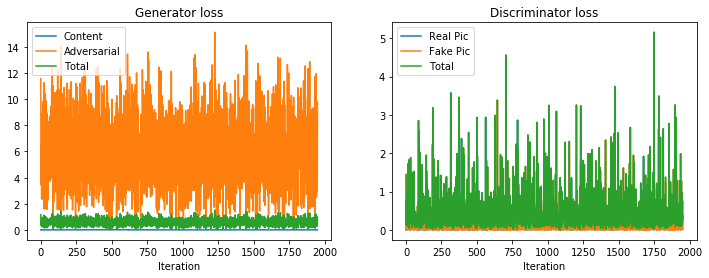


Epoch: 0, Iter: 2000, D: 1.545, G: 0.223, Time since last print (min): 2.554


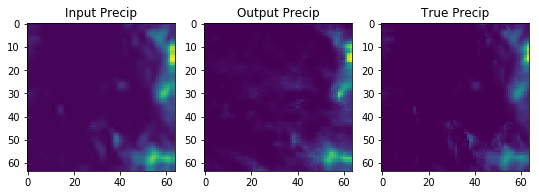

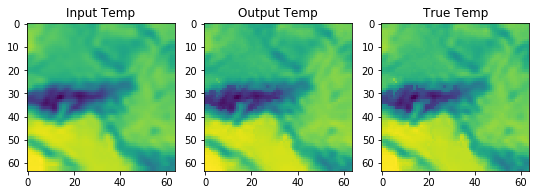

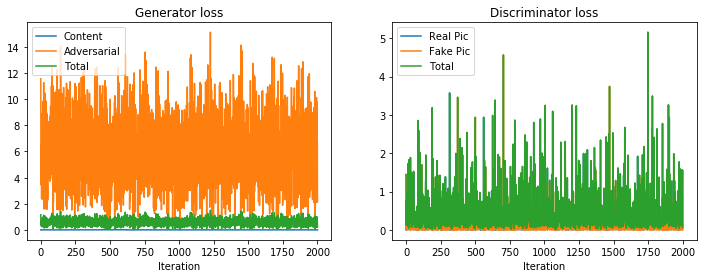


Epoch: 0, Iter: 2050, D: 1.17, G: 1.292, Time since last print (min): 2.555


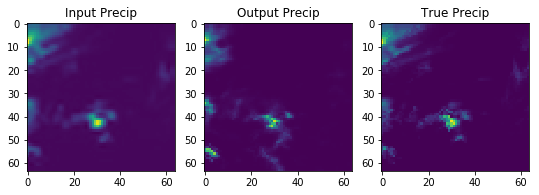

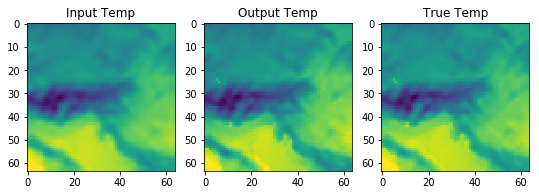

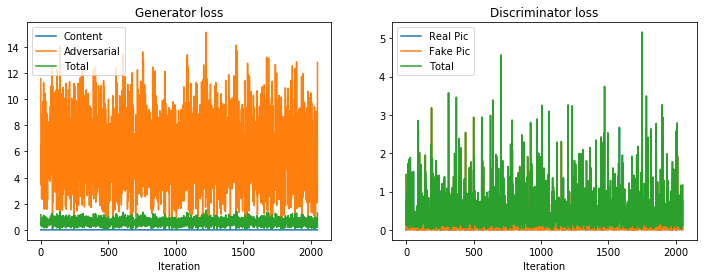


Epoch: 0, Iter: 2100, D: 0.1448, G: 0.4414, Time since last print (min): 2.556


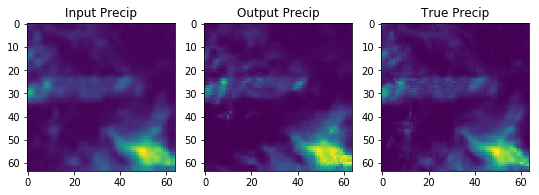

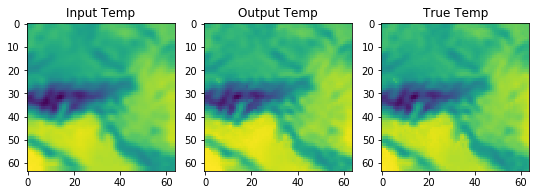

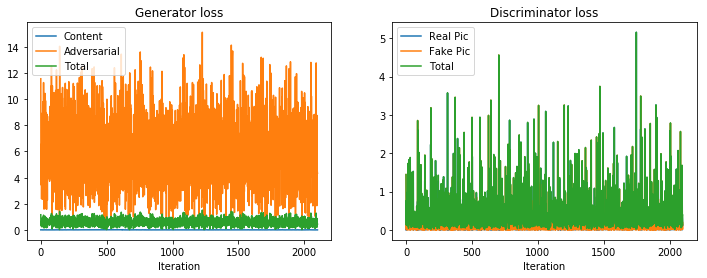


Epoch: 0, Iter: 2150, D: 0.3302, G: 0.4962, Time since last print (min): 2.557


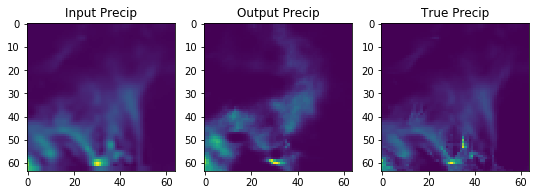

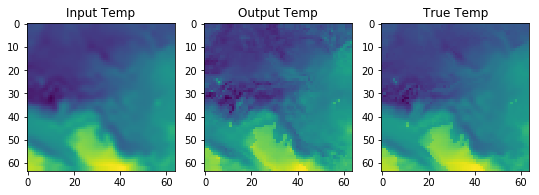

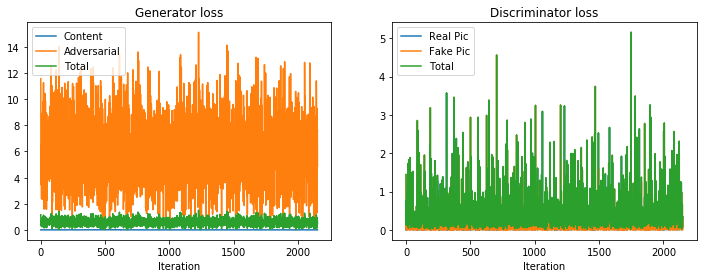


Epoch: 0, Iter: 2200, D: 0.1267, G: 0.498, Time since last print (min): 2.553


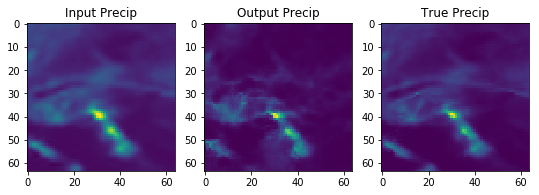

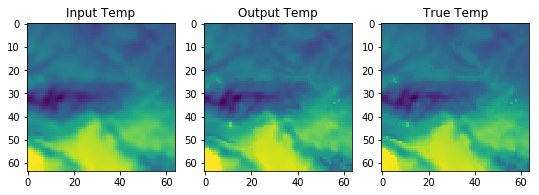

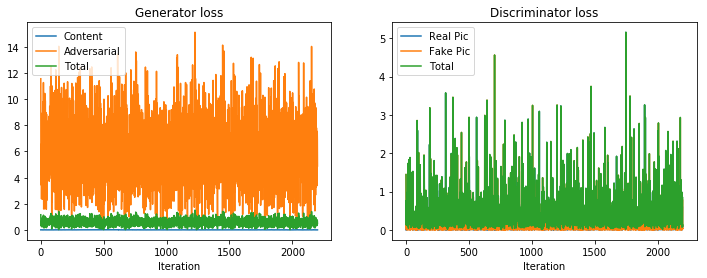


Epoch: 0, Iter: 2250, D: 0.7015, G: 0.2491, Time since last print (min): 2.554


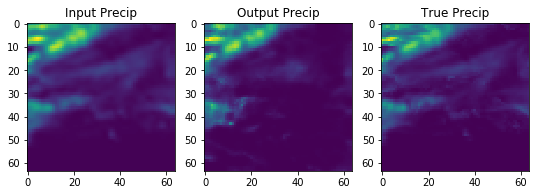

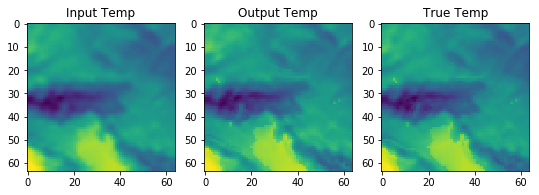

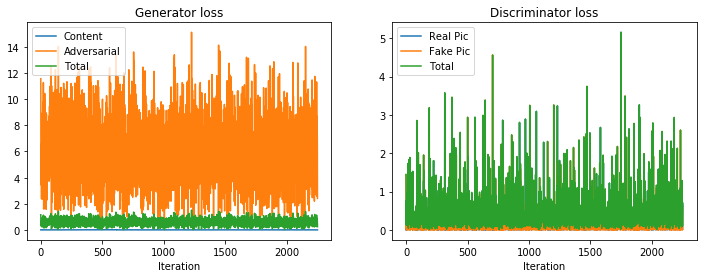

/home/shared/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: 1, Iter: 2300, D: 0.2619, G: 0.2223, Time since last print (min): 2.537


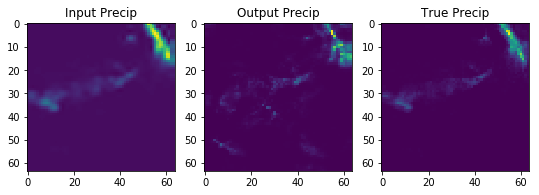

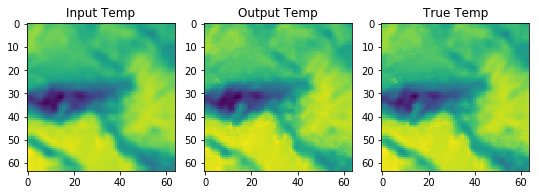

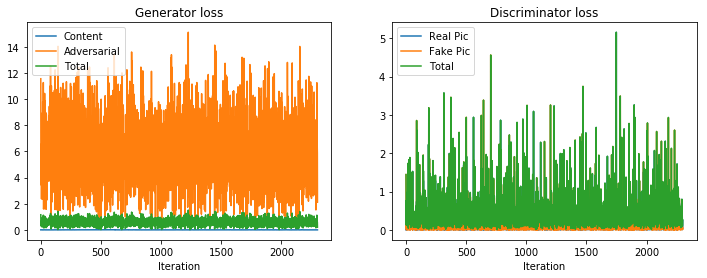


Epoch: 1, Iter: 2350, D: 1.292, G: 1.286, Time since last print (min): 2.559


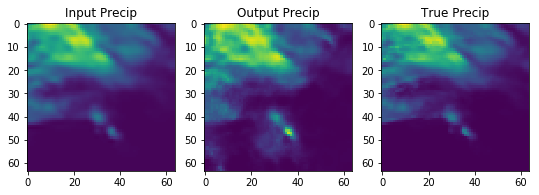

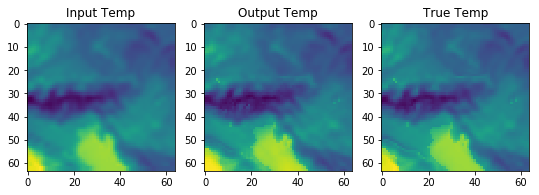

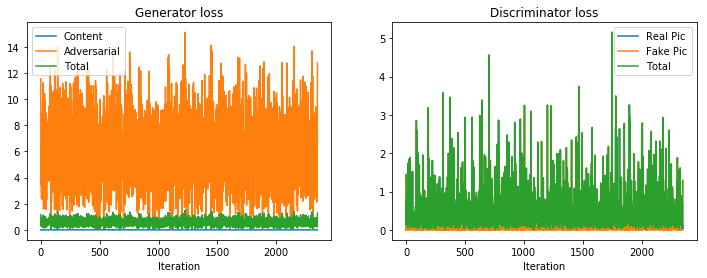


Epoch: 1, Iter: 2400, D: 0.2366, G: 0.8859, Time since last print (min): 2.556


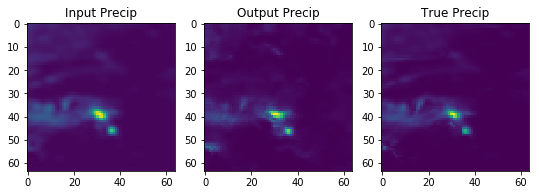

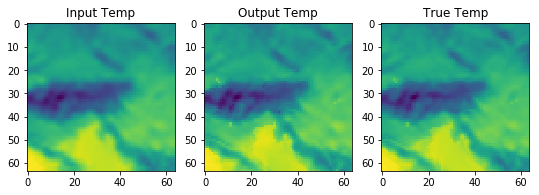

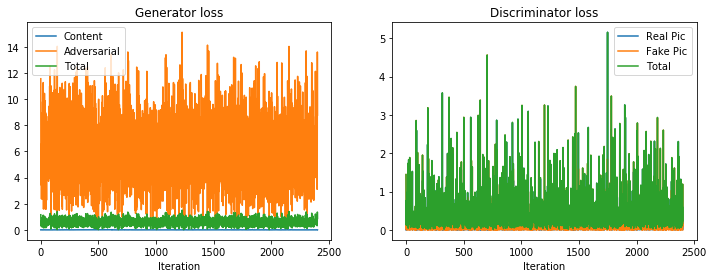


Epoch: 1, Iter: 2450, D: 0.5442, G: 1.026, Time since last print (min): 2.554


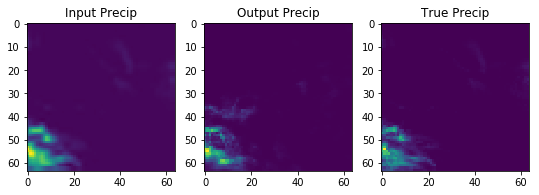

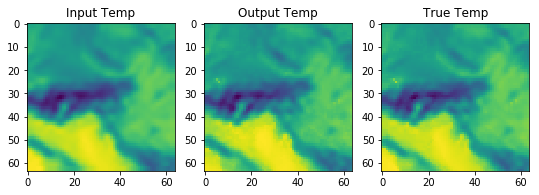

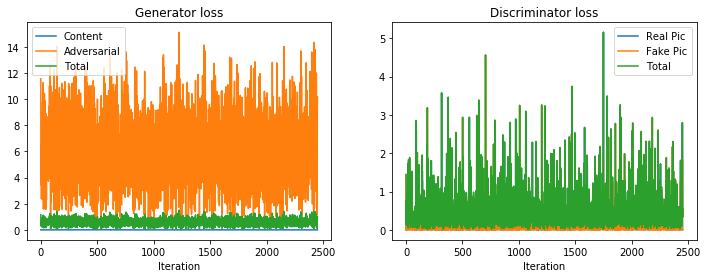


Epoch: 1, Iter: 2500, D: 0.362, G: 0.7164, Time since last print (min): 2.555


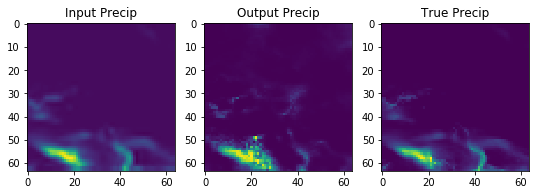

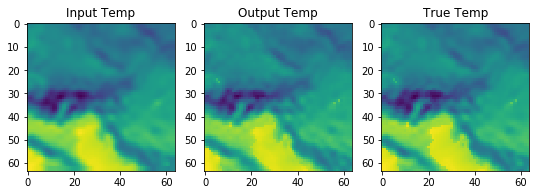

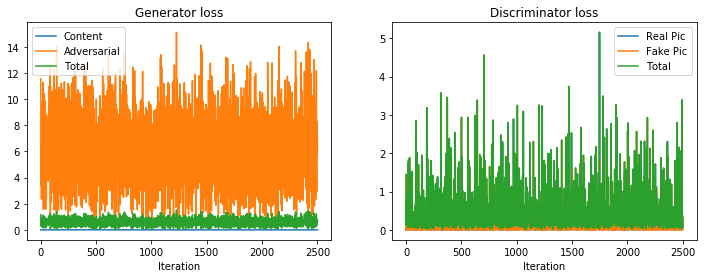


Epoch: 1, Iter: 2550, D: 0.07047, G: 0.5786, Time since last print (min): 2.555


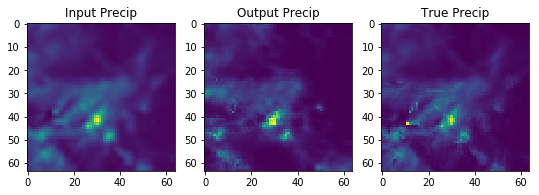

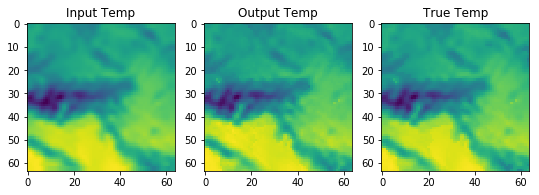

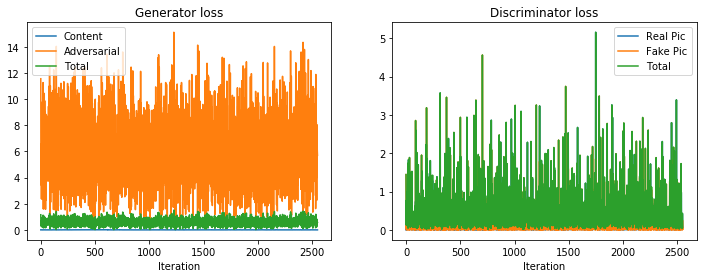


Epoch: 1, Iter: 2600, D: 0.3663, G: 0.8025, Time since last print (min): 2.555


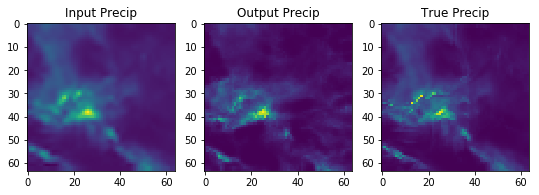

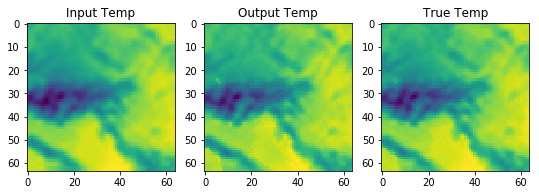

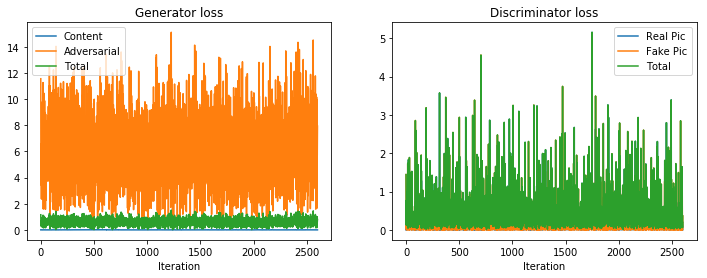

In [ ]:

D = Discriminator(num_channels=2, H=IMG_HEIGHT, W=IMG_WIDTH)
G = Generator(num_channels=3)

# Initialize the Generator to the checkpoint created when training it alone (only the first time)
# If you've already done this once and then trained the G and D together, use a checkpoint from that
# G.load_state_dict(torch.load('training_Generator_checkpoint.pt'))

# Load the checkpoints from training D and G together
G.load_state_dict(torch.load('GAN_Generator_checkpoint_full_data_2.pt'))
D.load_state_dict(torch.load('GAN_Discriminator_checkpoint_full_data_2.pt'))


D_solver = get_optimizer(D, lr=1e-4)
G_solver = get_optimizer(G, lr=1e-4)

run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, G_iters=1, show_every=50, num_epochs=2)

In [50]:
def check_accuracy(loader, model):
    model = model.to(device=device)
    model.eval() # set model to evaluation mode
    count, rmse_precip_ypred, rmse_temp_ypred = 0, 0, 0,
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            
            y_predicted = model(x)
            rmse_precip_ypred += torch.sqrt(torch.mean((y_predicted[:,0,:,:]-y[:,0,:,:]).pow(2)))
            rmse_temp_ypred += torch.sqrt(torch.mean((y_predicted[:,1,:,:]-y[:,1,:,:]).pow(2)))
            count += 1
            
        rmse_precip_ypred /= count
        rmse_temp_ypred /= count
        #print('RMSEs: \tOutput precip: %.3f\n\tOutput temp: %.3f\n\t' % 
        #      (rmse_precip_ypred, rmse_temp_ypred))
    return rmse_precip_ypred, rmse_temp_ypred

In [57]:
check_generator_accuracy(loader_val, G)

RMSEs: 	Input precip: 0.141
	Output precip: 0.127
	Input temp: 0.043
	Output temp: 0.135
	


In [59]:
check_discriminator_accuracy(loader_val, D, G)

In [11]:
# CHECKING ACCURACY SRGAN ON TEST SET
D = Discriminator(num_channels=2, H=IMG_HEIGHT, W=IMG_WIDTH)
G = Generator(num_channels=3)

G.load_state_dict(torch.load('GAN_Generator_checkpoint_full_data_2.pt'))
D.load_state_dict(torch.load('GAN_Discriminator_checkpoint_full_data_2.pt'))

check_generator_accuracy(loader_test, G)

RMSEs: 	Input precip: 0.144
	Output precip: 0.127
	Input temp: 0.043
	Output temp: 0.135
	


In [49]:
################## LOGGING-BEGIN #########################
# how often to log images
save_img_every = 500
exp_name = 'experiments/G_only_06_06'
writer = SummaryWriter(exp_name)
################## LOGGING-END ###########################

In [51]:
# We tried training the G and D in the GAN set up straight away, but that caused the G to make
# some really strange images that fooled the D, but didn't look anything like real images.
# Thus, we decided to train the G alone for just a bit, until it learned something like the
# identity function, and then used that as a starting point when training it in the GAN setup
def train_generator(optimizer, model, print_every=50, val_every = 500, save_img_every = 500, epochs=5):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    train_loss = np.zeros(len(loader_train)*epochs+1)
    rmse_precip = np.zeros(len(loader_train)*epochs+1)
    rmse_temp = np.zeros(len(loader_train)*epochs+1)
    best_rmse_temp_val = 10000
    best_rmse_precip_val = 10000
    iter_count = 0
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            y_predicted = model(x)
            loss_func = nn.MSELoss()
            loss = loss_func(y_predicted, y)
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
            rmse_precip[iter_count] = torch.sqrt(torch.mean((y_predicted[:, 0, :, :] - y[:, 0, :, :]).pow(2)))
            rmse_temp[iter_count] = torch.sqrt(torch.mean((y_predicted[:, 1, :, :] - y[:, 1, :, :]).pow(2)))
            
            if iter_count % val_every == 0:
                loss_total = 0 
                rmse_precip_val, rmse_temp_val = check_accuracy(loader_val, model)
                if rmse_precip_val < best_rmse_precip_val:
                    torch.save(model.cpu().state_dict(), 'training_G_06_05_best_precip.pt')
                    model = model.to(device=device)
                    best_rmse_precip_val = rmse_precip_val
                if rmse_temp_val < best_rmse_temp_val:
                    torch.save(model.cpu().state_dict(), 'training_G_06_05_best_temp.pt')
                    model = model.to(device=device)
                    best_rmse_temp_val = rmse_temp_val
                writer.add_scalars('Both precip RMSE',
                                      {'Train': rmse_precip[iter_count],
                                      'Val': rmse_precip_val}, iter_count)
                writer.add_scalars('Both temp RMSE',
                                      {'Train': rmse_temp[iter_count],
                                      'Val': rmse_temp_val}, iter_count)
            writer.add_scalar('Precip RMSE Train', rmse_precip[iter_count], iter_count)
            writer.add_scalar('Temp RMSE Train', rmse_temp[iter_count], iter_count)
            if iter_count % save_img_every == 0:
                # precip
                input_precip_grid = vutils.make_grid(x[0, 0, :, :])
                writer.add_image('Input precipitation', input_precip_grid, iter_count)
                output_precip_grid = vutils.make_grid(y_predicted[0, 0, :, :])
                writer.add_image('Output precipitation', output_precip_grid, iter_count)
                true_precip_grid = vutils.make_grid(y[0, 0, :, :])
                writer.add_image('True precipitation', true_precip_grid, iter_count)
                # temp
                input_temp_grid = vutils.make_grid(x[0, 1, :, :])
                writer.add_image('Input temperature', input_temp_grid, iter_count)
                output_temp_grid = vutils.make_grid(y_predicted[0, 1, :, :])
                writer.add_image('Output temperature', output_temp_grid, iter_count)
                true_temp_grid = vutils.make_grid(y[0, 1, :, :])
                writer.add_image('True temperature', true_temp_grid, iter_count)
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                
                plt.subplot(1,3,1)
                plt.imshow(x[0][0].cpu().detach().numpy())
                plt.title("Input Precip")
                plt.subplot(1,3,2)
                plt.imshow(y_predicted[0][0].cpu().detach().numpy())
                plt.title("Output Precip")
                plt.subplot(1,3,3)
                plt.imshow(y[0][0].cpu().detach().numpy())
                plt.title("True Precip")
                plt.show()
                
                plt.subplot(1,3,1)
                plt.imshow(x[0][1].cpu().detach().numpy())
                plt.title("Input Temp")
                plt.subplot(1,3,2)
                plt.imshow(y_predicted[0][1].cpu().detach().numpy())
                plt.title("Output Temp")
                plt.subplot(1,3,3)
                plt.imshow(y[0][1].cpu().detach().numpy())
                plt.title("True Temp")
                plt.show()
                
                #check_accuracy(loader_val, model)
                
            del x, y, loss
            iter_count += 1
            
        # At the end of training, save the model's state
        torch.save(model.cpu().state_dict(), 'training_G_final_06_06.pt')
        model = model.to(device=device)

In [ ]:
learning_rate = 1e-4

model = Generator(3)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_generator(optimizer, model, epochs=10)